In [1]:
%matplotlib notebook

In [2]:
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
import numpy as np
import subprocess as sp
import gzip
import pysam as ps
import csv
from pathlib import Path
from matplotlib.ticker import FormatStrFormatter
import yaml
import openpyxl

In [3]:
# Experiment directories and files
project_dir = Path().absolute().parents[1]
data_dir = project_dir / "data"
config_dir = project_dir / "config"
results_dir = project_dir / "results"
truth_dir = data_dir / "truth"
calls_dir, eval_dir, benchmark_dir = {}, {}, {}
for project in ["Dong", "Wang"]:
    calls_dir[project] = results_dir / "calls" / project
    eval_dir[project] = results_dir / "eval" / project
    benchmark_dir[project] = results_dir / "benchmarks" / project
figure_dir = results_dir / "figures"
tables_dir = results_dir / "tables"

caller_order = ["Octopus", "SCcaller", "MonoVar", "Prosolo"]

caller_colours = {
    'Octopus': sns.xkcd_rgb["windows blue"],
    'SCcaller': sns.xkcd_rgb["pale red"],
    'Prosolo': sns.xkcd_rgb["faded green"],
    'MonoVar': sns.xkcd_rgb["amber"]
}

caller_linestyles = {
    'Octopus': '',
    'SCcaller': (1,2),
    'Prosolo': (6,3),
    'MonoVar': (2,2)
}

caller_pass_scores = {
    'Octopus': 5.,
    'SCcaller': None,
    'MonoVar': None,
    'Prosolo': None
}

In [4]:
def read_experiments(config_filename):
    with config_filename.open() as config_file:
        config = yaml.load(config_file, Loader=yaml.FullLoader)
        res = []
        for control in config["groups"]["controls"]:
            for test in config["groups"][config["test"]]:
                experiment = config.copy()
                experiment["group"] = config["test"]
                experiment["control"] = control
                experiment["test"] = test
                del experiment["groups"]
                res.append(experiment)
        return res

In [5]:
dong_experiments = read_experiments(config_dir / "dong.yaml")

In [6]:
def read_vcfeval_performance_summary(rtg_vcfeval_dir, optimal=False):
    with (rtg_vcfeval_dir / 'summary.txt').open() as summary:
        lines = summary.readlines()
        header, stats = lines[0].strip().split(), lines[-2 if optimal else -1].strip().split()
        result = pd.DataFrame([stats[1:]], columns=header[1:]).reset_index(drop=True)
        for column in result.columns:
            try:
                result[column] = pd.to_numeric(result[column])
            except: continue
        return result
    return None

def read_vcfeval_roc_header(rtg_vcfeval_roc_filename):
    with gzip.open(rtg_vcfeval_roc_filename, 'rt') as roc:
        result = None
        for line in roc:
            if line.startswith('#'):
                result = line.strip()[1:].split('\t')
            else:
                break
        return result

def get_vcfeval_roc_filename(variant_type):
    if variant_type == 'snv' or variant_type == 'snp':
        return 'snp_roc.tsv.gz'
    elif variant_type == 'indel':
        return 'non_snp_roc.tsv.gz'
    else:
        return 'weighted_roc.tsv.gz'

def read_vcfeval_roc(vcfeval_dir, variant_type='all'):
    roc = vcfeval_dir / get_vcfeval_roc_filename(variant_type)
    result = pd.read_csv(roc, sep='\t', comment='#')
    result.columns = read_vcfeval_roc_header(roc)
    return result

In [7]:
def get_vcfeval_dir(experiment, caller, genotypes=True, raw=True):
    return eval_dir[experiment["project"]] / (experiment["group"] + '.' + experiment["reference"] + '.' + experiment["mapper"] + '.' + caller + "." + experiment["test"] + ".vs." + experiment["control"] + ('.raw' if raw else '.pass') + ('.GT' if genotypes else '.AL') + '.vcfeval')

def read_vcfeval_df_helper(experiments, summary_df_getter, genotypes=True, raw=True):
    dfs = []
    for experiment in experiments:
        for caller in experiment["callers"]:
            caller_vcfeval_dir = get_vcfeval_dir(experiment, caller, genotypes=genotypes, raw=raw)
            if caller_vcfeval_dir.exists():
                try:
                    df = summary_df_getter(experiment, caller_vcfeval_dir)
                    df.insert(0, "Group", experiment["group"])
                    df.insert(0, "Control", experiment["control"])
                    df.insert(1, "Test", experiment["test"])
                    df.insert(3, "Caller", caller)
                    dfs.append(df)
                except FileNotFoundError:
                    continue
    if len(dfs) > 0:
        return pd.concat(dfs).reset_index(drop=True)
    else:
        return None

def read_vcfeval_df_helper2(experiments, summary_df_getter, alleles=True):
    dfs = []
    filtered_gt_df = read_vcfeval_df_helper(experiments, summary_df_getter, genotypes=True, raw=False)
    if filtered_gt_df is not None:
        filtered_gt_df.insert(3, "Filtered", True)
        filtered_gt_df.insert(4, "Match", "GT")
        dfs.append(filtered_gt_df)
    raw_gt_df = read_vcfeval_df_helper(experiments, summary_df_getter,  genotypes=True, raw=True)
    if raw_gt_df is not None:
        raw_gt_df.insert(3, "Filtered", False)
        raw_gt_df.insert(4, "Match", "GT")
        dfs.append(raw_gt_df)
    if alleles:
        filtered_alleles_df = read_vcfeval_df_helper(experiments, summary_df_getter,  genotypes=False, raw=False)
        if filtered_alleles_df is not None:
            filtered_alleles_df.insert(3, "Filtered", True)
            filtered_alleles_df.insert(4, "Match", "AL")
            dfs.append(filtered_alleles_df)
        raw_alleles_df = read_vcfeval_df_helper(experiments, summary_df_getter,  genotypes=False, raw=True)
        if raw_alleles_df is not None:
            raw_alleles_df.insert(3, "Filtered", False)
            raw_alleles_df.insert(4, "Match", "AL")
            dfs.append(raw_alleles_df)
    return pd.concat(dfs).reset_index(drop=True)

def read_vcfeval_performance_summaries(experiments, optimal=False):
    return read_vcfeval_df_helper2(experiments, lambda _, d: read_vcfeval_performance_summary(d, optimal))

def read_vcfeval_rocs(experiments):
    return read_vcfeval_df_helper2(experiments, lambda _, d: read_vcfeval_roc(d))

In [8]:
def count_records(vcf_path, matches=None):
    vcf = ps.VariantFile(vcf_path)
    return sum(1 if matches is None else matches(record) for record in vcf)

def is_indel(ref, alt, min_size=None, max_size=None):
    if min_size is None and max_size is None:
        return len(alt) != len(ref)
    else:
        size = abs(len(alt) - len(record.ref))
        if min_size is None:
            return size <= max_size
        elif max_size is None:
            return size >= min_size
        else:
            return min_size <= size <= max_size

def has_indel(record, min_size=None):
    return any(is_indel(record.ref, alt, min_size=min_size) for alt in record.alts)

def count_indel_records(vcf_path, min_size=None):
    return count_records(vcf_path, lambda record: has_indel(record, min_size))

def count_alt_indels(record, min_size=None):
    return sum(is_indel(record.ref, alt) for alt in record.alts)

def count_called_indels(vcf_path, min_size=None):
    vcf = ps.VariantFile(vcf_path)
    return sum(count_alt_indels(record, min_size=min_size) for record in vcf)

def subset_vcf(in_vcf_path, bed_regions, out_vcf_path):
    cmd = ['bcftools', 'view', '-T', bed_regions, '-Oz', '-o', out_vcf_path, in_vcf_path]
    call(cmd)
    index(out_vcf_path)

def read_indel_size_distribution(vcf_path, bed_regions=None):
    if bed_regions is not None:
        tmp_vcf = vcf_path.replace('.vcf', '.tmp.vcf')
        subset_vcf(vcf_path, bed_regions, tmp_vcf)
        res = read_indel_size_distribution(tmp_vcf)
        remove_vcf(tmp_vcf)
        return res
    vcf = ps.VariantFile(vcf_path)
    dist = {}
    min_size, max_size = None, None
    for record in vcf:
        for alt in record.alts:
            if is_indel(record.ref, alt):
                size = len(alt) - len(record.ref)
                if size in dist:
                    dist[size] += 1
                else:
                    dist[size] = 1
                if min_size is None:
                    min_size = size
                    max_size = min_size
                else:
                    min_size = min(min_size, size)
                    max_size = max(max_size, size)
    if max_size is not None:
        sizes = list(range(min_size, max_size + 1))
    else:
        sizes = []
    counts = [dist[size] if size in dist else 0 for size in sizes]
    return sizes, counts, dist

def read_indel_size_distribution_df(vcf_path, bed_regions=None):
    sizes, counts, _ = read_indel_size_distribution(vcf_path, bed_regions=bed_regions)
    result = pd.DataFrame({'size': sizes, 'count': counts})
    result[['size', 'count']] = result[['size', 'count']].astype(int)
    return result

def read_indel_size_distributions(experiments, baseline=True):
    vcf = "tp-baseline.vcf.gz" if baseline else "tp.vcf.gz"
    return read_vcfeval_df_helper2(experiments, lambda _, d: read_indel_size_distribution_df(d / vcf))

In [9]:
def read_vaf_df(vcf_path, sample):
    vcf = ps.VariantFile(vcf_path)
    allele_depths = []
    for rec in vcf:
        if len(rec.alts) == 1 and "AD" in rec.samples[sample] and all(a is not None for a in rec.samples[sample]["GT"]) and sum(rec.samples[sample]["GT"]) == 1:
            allele_depths.append(rec.samples[sample]["AD"])
    if len(allele_depths) > 0:
        result = pd.DataFrame(allele_depths, columns=["REF", "ALT"])
        result["VAF"] = result.apply(lambda row: row.ALT / max(row.REF + row.ALT, 1), axis=1)
        return result
    else:
        return pd.DataFrame([], columns=["REF", "ALT", "VAF"])

def read_vaf_dfs(vcfeval_dir, sample):
    tp_df = read_vaf_df(vcfeval_dir / "tp.vcf.gz", sample)
    tp_df["Kind"] = "TP"
    fp_df = read_vaf_df(vcfeval_dir / "fp.vcf.gz", sample)
    fp_df["Kind"] = "FP"
    return pd.concat([tp_df, fp_df])

def read_vaf_distributions(experiments):
    return read_vcfeval_df_helper2(experiments, lambda experiment, d: read_vaf_dfs(d, experiment["test"]))

In [10]:
def add_precision_recall(ax, df, ylim=None, xlim=None, despine=True,
                         title=None, legend=True, legend_title=False,
                         linewidth=None,
                         y_format='%.3f', x_format='%.3f',
                         ylabel='Precision (PPV)', xlabel='Sensitivity'):
    if legend:
        legend = 'brief'
    callers = list(df["Caller"].unique())
    sns.lineplot(x="sensitivity", y="precision",
                 hue="Caller",
                 style="Caller",
                 palette=caller_colours,
                 #dashes=caller_linestyles,
                 linewidth=linewidth,
                 hue_order=list(reversed(caller_order)),
                 legend=legend, data=df, ax=ax)
    ax.set(ylabel=ylabel, xlabel=xlabel)
    ax.yaxis.set_major_formatter(FormatStrFormatter(y_format))
    ax.xaxis.set_major_formatter(FormatStrFormatter(x_format))
    if legend and not legend_title:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles=handles[1:], labels=labels[1:])
    if despine:
        sns.despine(ax=ax)
    if title is not None:
        ax.set(title=title)
    if ylim:
        ax.set_ylim(ylim[0], ylim[1])
    if xlim:
        ax.set_xlim(xlim[0], xlim[1])
    return ax

def add_marker(ax, x, y, colour, style='o', size=50):
    sns.regplot(x=np.array([x]), y=np.array([y]), scatter=True, fit_reg=False,
                marker=style, color=colour, scatter_kws={"s": size}, ax=ax)

def find_marker(df, caller, score):
    df = df.replace('None', 0)
    df['score'] = df['score'].apply(pd.to_numeric)
    if score is not None:
        for tol in [1e-10, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, .5]:
            lines = df[(df.Caller == caller) & np.isclose(df.score, score, atol=tol)]
            if lines.shape[0] > 0:
                break
    else:
        score = df.query("Caller=='" + caller + "'").score.min()
        lines = df[(df.Caller == caller) & (df.score == score)]
    if lines.shape[0] == 0:
        raise Exception("Could not find a PASS marker for " + caller)
    return float(lines['sensitivity'].iloc[0]), float(lines['precision'].iloc[0])

def find_optimal_marker(df, caller):
    max_fmeasure = df.query("Caller=='" + caller + "'").f_measure.max()
    lines = df[(df.Caller == caller) & (df.f_measure == max_fmeasure)] 
    if lines.shape[0] == 0:
        raise Exception("Could not find a PASS marker for " + caller)
    return float(lines['sensitivity'].iloc[0]), float(lines['precision'].iloc[0])

def plot_precision_recall(df, 
                          ylim=None, xlim=None,
                          marker_scores=None,
                          linewidth=None,
                          title=None, legend_out=True,
                          y_format='%.1f', x_format='%.1f',
                          save=None, save_format='pdf'):
    sns.set(style="whitegrid")
    fig, ax = plt.subplots(figsize=(9, 6))
    add_precision_recall(ax, df, linewidth=linewidth, ylim=ylim, xlim=xlim, y_format=y_format, x_format=x_format, title=title)
    callers = list(df["Caller"].unique())
    if marker_scores is not None:
        for caller in reversed(callers):
            if caller in list(df['Caller'].unique()) and caller in marker_scores:
                try:
                    marker_x, marker_y = find_marker(df, caller, caller_pass_scores[caller])
                    add_marker(ax, marker_x, marker_y, caller_colours[caller])
                except:
                    print('Could not add PASS marker for ', caller)
    if legend_out:
        handles, labels = ax.get_legend_handles_labels()
        lgd = fig.legend(handles=reversed(handles), labels=reversed(labels),
                         frameon=False, loc='upper center',
                         bbox_to_anchor=(0.5, 1.03),
                         borderaxespad=0, ncol=len(labels))
        ax.legend_.remove()
    plt.tight_layout()
    if save is None:
        plt.show()
    else:
        plt.savefig(save, format=save_format, transparent=True, bbox_inches='tight')

def add_precision_recalls(axes, dfs, linewidth=None, titles=None, ylims=None, xlims=None, y_format=None, x_format=None, xlabel='Sensitivity'):
    if titles is None:
        titles = len(dfs) * [None]
    for df, title, ax, ylim, xlim in zip(dfs, titles, axes, ylims, xlims):
        add_precision_recall(ax, df,
                             linewidth=linewidth,
                             ylim=ylim, xlim=xlim,
                             y_format=y_format, x_format=x_format,
                             title=title,
                             legend_title=True,
                             xlabel=xlabel)
    for ax in axes[1:]:
        ax.set(ylabel='')

def add_markers(dfs, marker_scores, axes):
    for df, ax in zip(dfs, axes):
        callers = list(df["Caller"].unique())
        for caller in reversed(callers):
            if caller in marker_scores:
                try:
                    marker_x, marker_y = find_marker(df, caller, caller_pass_scores[caller])
                    add_marker(ax, marker_x, marker_y, caller_colours[caller], size=50)
                except:
                    print('Could not add PASS marker for ', caller)

def add_optimal_markers(dfs, axes):
    for df, ax in zip(dfs, axes):
        callers = list(df["Caller"].unique())
        for caller in reversed(callers):
            try:
                marker_x, marker_y = find_optimal_marker(df, caller)
                add_marker(ax, marker_x, marker_y, caller_colours[caller], style='*', size=100)
            except:
                print('Could not add PASS marker for ', caller)

def plot_precision_recalls(dfs,
                           linewidth=None,
                           titles=None,
                           xlims=None, ylims=None,
                           y_format='%.1f', x_format='%.1f',
                           marker_scores=None,
                           optimal_marker_scores=False,
                           ncols=4,
                           save=None, save_format='pdf'):
    sns.set(style="whitegrid")
    n_subplots = len(dfs)
    nrows, ncols = int(n_subplots/ncols), min(n_subplots, ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2*ncols*ncols, 2*ncols*nrows))
    if ylims is None: 
        ylims = len(dfs) * [None]
    elif type(ylims) is not list:
        ylims = len(dfs) * [ylims]
    if xlims is None:
        xlims = len(dfs) * [None]
    elif type(xlims) is not list:
        xlims = len(dfs) * [xlims]
    for i in range(nrows - 1):
        add_precision_recalls(axes.flat[i*ncols:i*ncols+ncols], 
                              dfs[i*ncols:i*ncols+ncols],
                              linewidth=linewidth,
                              titles=titles[i*ncols:i*ncols+ncols],
                              ylims=ylims[i*ncols:i*ncols+ncols],
                              xlims=xlims[i*ncols:i*ncols+ncols],
                              y_format=y_format, x_format=x_format,
                              xlabel='')
    add_precision_recalls(axes.flat[-ncols:],
                          dfs[-ncols:],
                          linewidth=linewidth,
                          titles=titles[-ncols:],
                          ylims=ylims, xlims=xlims,
                          y_format=y_format, x_format=x_format)
    if marker_scores is not None:
        add_markers(dfs, marker_scores, axes.flat)
    if optimal_marker_scores:
        add_optimal_markers(dfs, axes.flat)
    handles, labels = axes.flat[-1].get_legend_handles_labels()
    lgd = fig.legend(handles=reversed(handles), labels=reversed(labels),
                     frameon=False, loc='upper center',
                     bbox_to_anchor=(0.5, 1.03),
                     borderaxespad=0, ncol=len(labels))
    for ax in axes.flat:
        ax.legend_.remove()
    plt.tight_layout()
    if save is None:
        plt.show()
    else:
        plt.savefig(save, format=save_format, transparent=True, bbox_extra_artists=[lgd], bbox_inches='tight')

In [11]:
dong_summary_df = read_vcfeval_performance_summaries(dong_experiments)

In [963]:
dong_summary_df.query('Filtered and Match=="GT" and Control=="IL1C" and (Test=="IL11" or Test=="IL12")')

Control  Test             Group  Filtered Match    Caller  \
40    IL1C  IL11  clones_and_cells      True    GT   Octopus   
41    IL1C  IL11  clones_and_cells      True    GT   MonoVar   
42    IL1C  IL11  clones_and_cells      True    GT  SCcaller   
43    IL1C  IL11  clones_and_cells      True    GT   Prosolo   
44    IL1C  IL12  clones_and_cells      True    GT   Octopus   
45    IL1C  IL12  clones_and_cells      True    GT   MonoVar   
46    IL1C  IL12  clones_and_cells      True    GT  SCcaller   
47    IL1C  IL12  clones_and_cells      True    GT   Prosolo   

    True-pos-baseline  True-pos-call  False-pos  False-neg  Precision  \
40            4242279        4276192     384537     201062     0.9175   
41            3485647        3486043    1869858     956814     0.6509   
42            2375901        2375879     123649    2067493     0.9505   
43            2882234        2882416     646820    1561147     0.8167   
44            4236737        4270558     386680     206604     0.9170   
45            2984395        2984701    1969809    1458188     0.6024   
46            1828164        1828173     207106    2615230     0.8982   
47            2740211        2740348     742329    1703170     0.7869   

    Sensitivity  F-measure  
40       0.9547     0.9358  
41       0.7846     0.7115  
42       0.5347     0.6844  
43       0.6487     0.7231  
44       0.9535     0.9349  
45       0.6718     0.6352  
46       0.4114     0.5644  
47       0.6167     0.6915

In [12]:
agg_summary_df = dong_summary_df.query("Filtered and Control=='IL1C'").groupby(["Caller", "Filtered", "Match"]).agg({
    "True-pos-baseline": "sum",
    "True-pos-call": "sum",
    "False-pos": "sum",
    "False-neg": "sum",
}).reset_index()
agg_summary_df["Precision"] = agg_summary_df["True-pos-baseline"] / (agg_summary_df["True-pos-baseline"] + agg_summary_df["False-pos"])
agg_summary_df["Sensitivity"] = agg_summary_df["True-pos-baseline"] / (agg_summary_df["True-pos-baseline"] + agg_summary_df["False-neg"])
agg_summary_df["F-measure"] = (2 * agg_summary_df["Sensitivity"] * agg_summary_df["Precision"]) / (agg_summary_df["Sensitivity"] + agg_summary_df["Precision"])
agg_summary_df

Caller  Filtered Match  True-pos-baseline  True-pos-call  False-pos  \
0   MonoVar      True    AL           20706127       20711136   10781721   
1   MonoVar      True    GT           19890252       19892399   11393047   
2   Octopus      True    AL           25601116       25654148    2301427   
3   Octopus      True    GT           25441728       25645009    2312098   
4   Prosolo      True    AL           17395675       17398011    3688898   
5   Prosolo      True    GT           17010490       17011497    4074923   
6  SCcaller      True    AL           13176590       13176317     107277   
7  SCcaller      True    GT           12451104       12450997     832579   

   False-neg  Precision  Sensitivity  F-measure  
0    5954230   0.657591     0.776664   0.712185  
1    6762637   0.635811     0.746270   0.686626  
2    1059248   0.917519     0.960269   0.938407  
3    1218318   0.916693     0.954302   0.935119  
4    9264689   0.825043     0.652492   0.728692  
5    9649796   0.806742     0.638046   0.712545  
6   13483774   0.991924     0.494239   0.659749  
7   14209260   0.937323     0.467027   0.623427

In [30]:
def format_float_latex(val):
    return str("\\num[group-separator={,}]{") + str(val) + "}"

formatters = {
    "True-pos-baseline": format_float_latex,
    "False-pos": format_float_latex,
    "False-neg": format_float_latex,
}

agg_summary_df.drop(columns=["Filtered", "True-pos-call"]).to_latex(tables_dir / "dong_agg_summary.tex", index=False, formatters=formatters, escape=False)

In [18]:
dong_summary_df.to_excel(tables_dir / "dong_summary.xlsx")

In [750]:
dong_optimal_summary_df = read_vcfeval_performance_summaries(dong_experiments, optimal=True)

In [751]:
dong_optimal_summary_df

Control  Test             Group  Filtered Match    Caller  \
0    Hunamp  IL-2  clones_and_cells      True    GT   Octopus   
1    Hunamp  IL-2  clones_and_cells      True    GT   MonoVar   
2    Hunamp  IL-2  clones_and_cells      True    GT  SCcaller   
3    Hunamp  IL-2  clones_and_cells      True    GT   Prosolo   
4    Hunamp  IL-3  clones_and_cells      True    GT   Octopus   
..      ...   ...               ...       ...   ...       ...   
187    IL1C  IL11  clones_and_cells     False    AL   Prosolo   
188    IL1C  IL12  clones_and_cells     False    AL   Octopus   
189    IL1C  IL12  clones_and_cells     False    AL   MonoVar   
190    IL1C  IL12  clones_and_cells     False    AL  SCcaller   
191    IL1C  IL12  clones_and_cells     False    AL   Prosolo   

     True-pos-baseline  True-pos-call  False-pos  False-neg  Precision  \
0              4146714        4177582     212562     292214     0.9516   
1              3425299        3425621     938677    1012457     0.7849   
2              2583351        2583329      94125    1855632     0.9648   
3              2848912        2849113     376516    1590057     0.8833   
4              4133335        4163616     224354     305593     0.9489   
..                 ...            ...        ...        ...        ...   
187            3104049        3104627     262680    2307695     0.9220   
188            4473222        4482180     316023     938546     0.9341   
189            3226898        3227551     851998    2184869     0.7912   
190            2356236        2356145      14943    3055532     0.9937   
191            3043288        3043833     254408    2368480     0.9229   

     Sensitivity  F-measure  
0         0.9342     0.9428  
1         0.7719     0.7783  
2         0.5820     0.7260  
3         0.6418     0.7434  
4         0.9312     0.9399  
..           ...        ...  
187       0.5736     0.7072  
188       0.8266     0.8771  
189       0.5963     0.6800  
190       0.4354     0.6055  
191       0.5623     0.6988  

[192 rows x 13 columns]

<IPython.core.display.Javascript object>


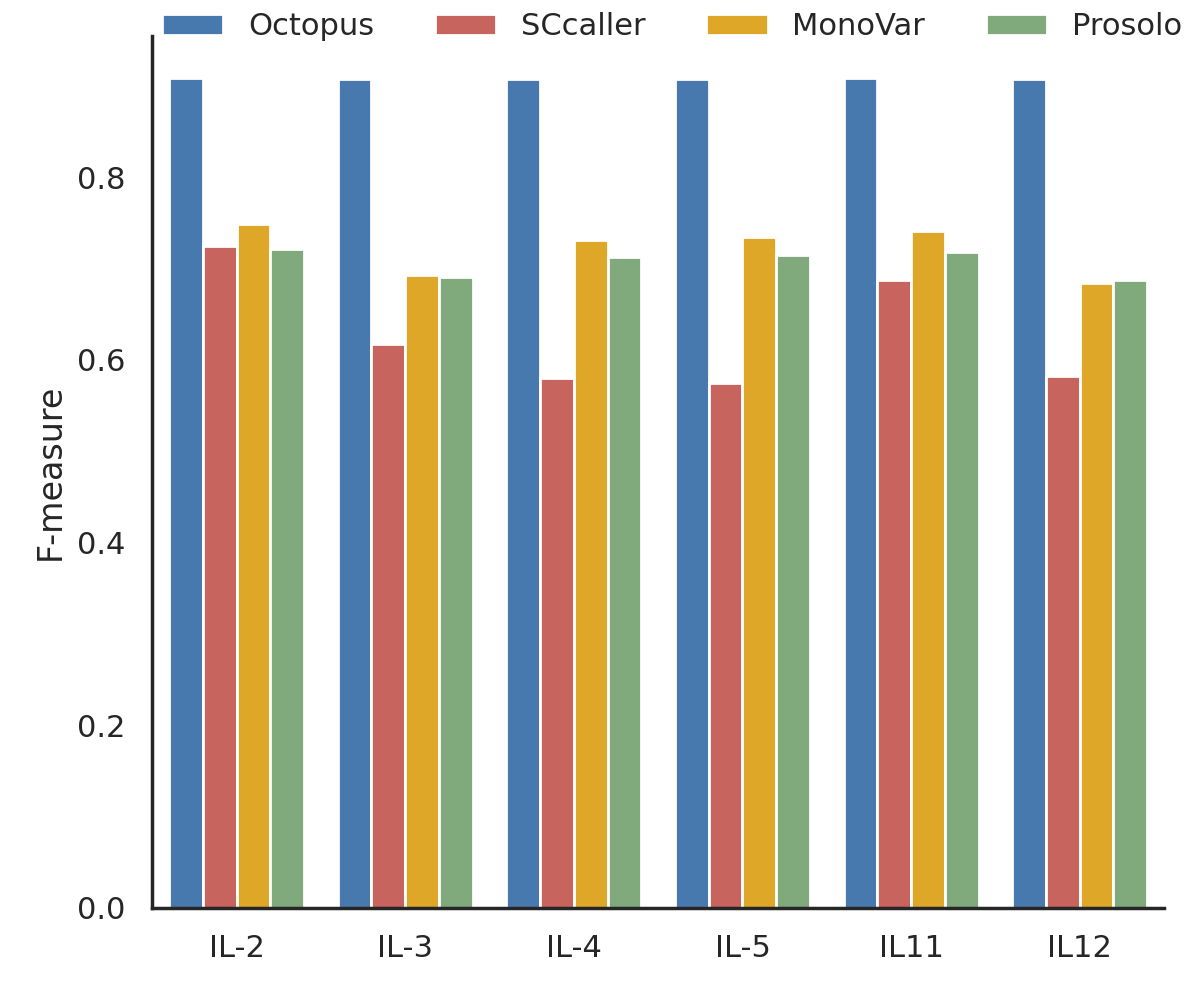

In [752]:
sns.set(style="white")
fig, ax = plt.subplots(figsize=(6, 5))
g = sns.barplot(x="Test", y="F-measure", hue="Caller",
                hue_order=caller_order,
                palette=caller_colours, ci=None,
                data=optimal_summary_df.query("Control=='IL1C'"),
                ax=ax)
sns.despine(ax=ax)
ax.set(xlabel='')
handles, labels = ax.get_legend_handles_labels()
lgd = fig.legend(handles=handles, labels=labels, frameon=False,
                 loc='upper center',
                 bbox_to_anchor=(0.56, 1.),
                 borderaxespad=0, ncol=len(labels))
ax.legend_.remove()
plt.tight_layout()
plt.savefig(figure_dir / "dong_fmeasures.pdf", format="pdf", transparent=True, bbox_inches='tight')

In [19]:
rocs = read_vcfeval_rocs(dong_experiments)
filterd_rocs, raw_rocs = rocs.query('Filtered'), rocs.query('not Filtered')

<IPython.core.display.Javascript object>


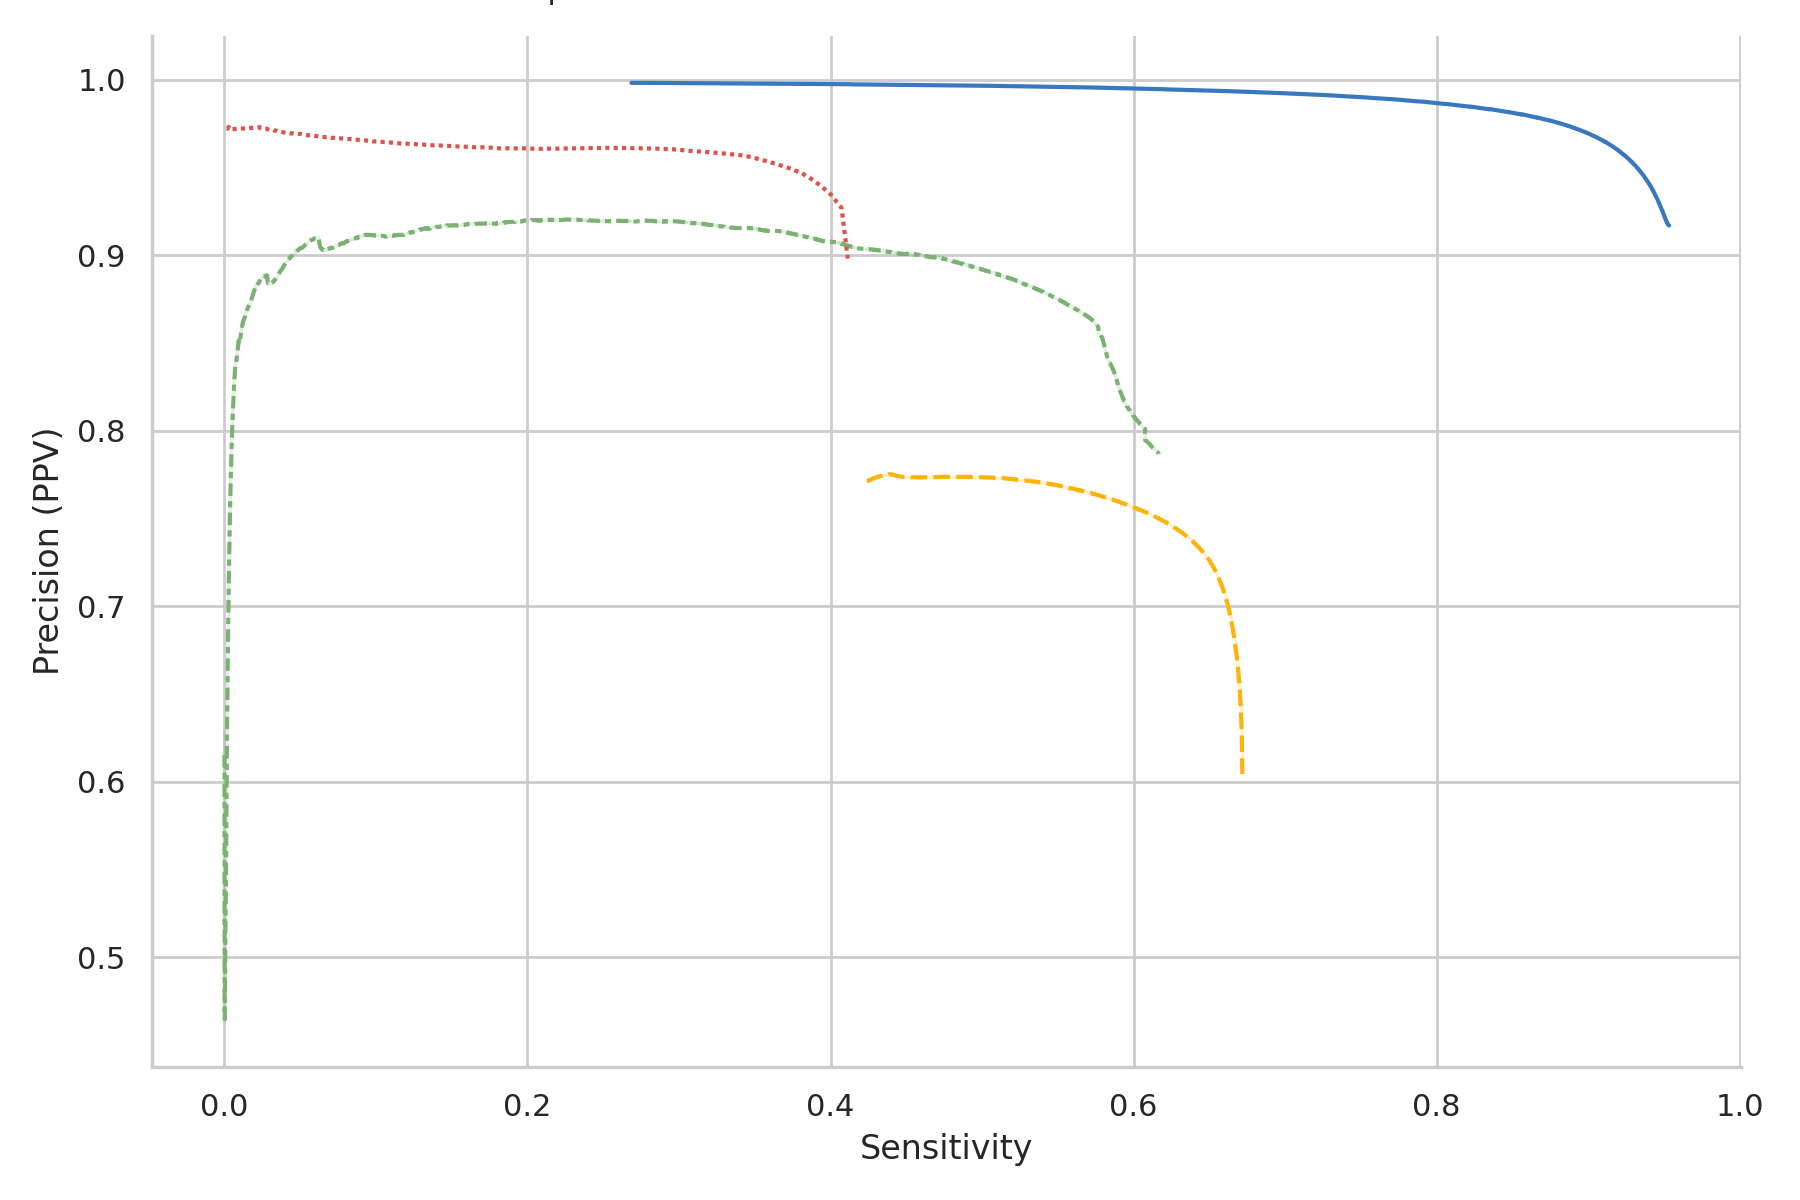

In [20]:
plot_precision_recall(filterd_rocs.query("Match=='GT' and Control=='IL1C' and Test=='IL12'"))

<IPython.core.display.Javascript object>


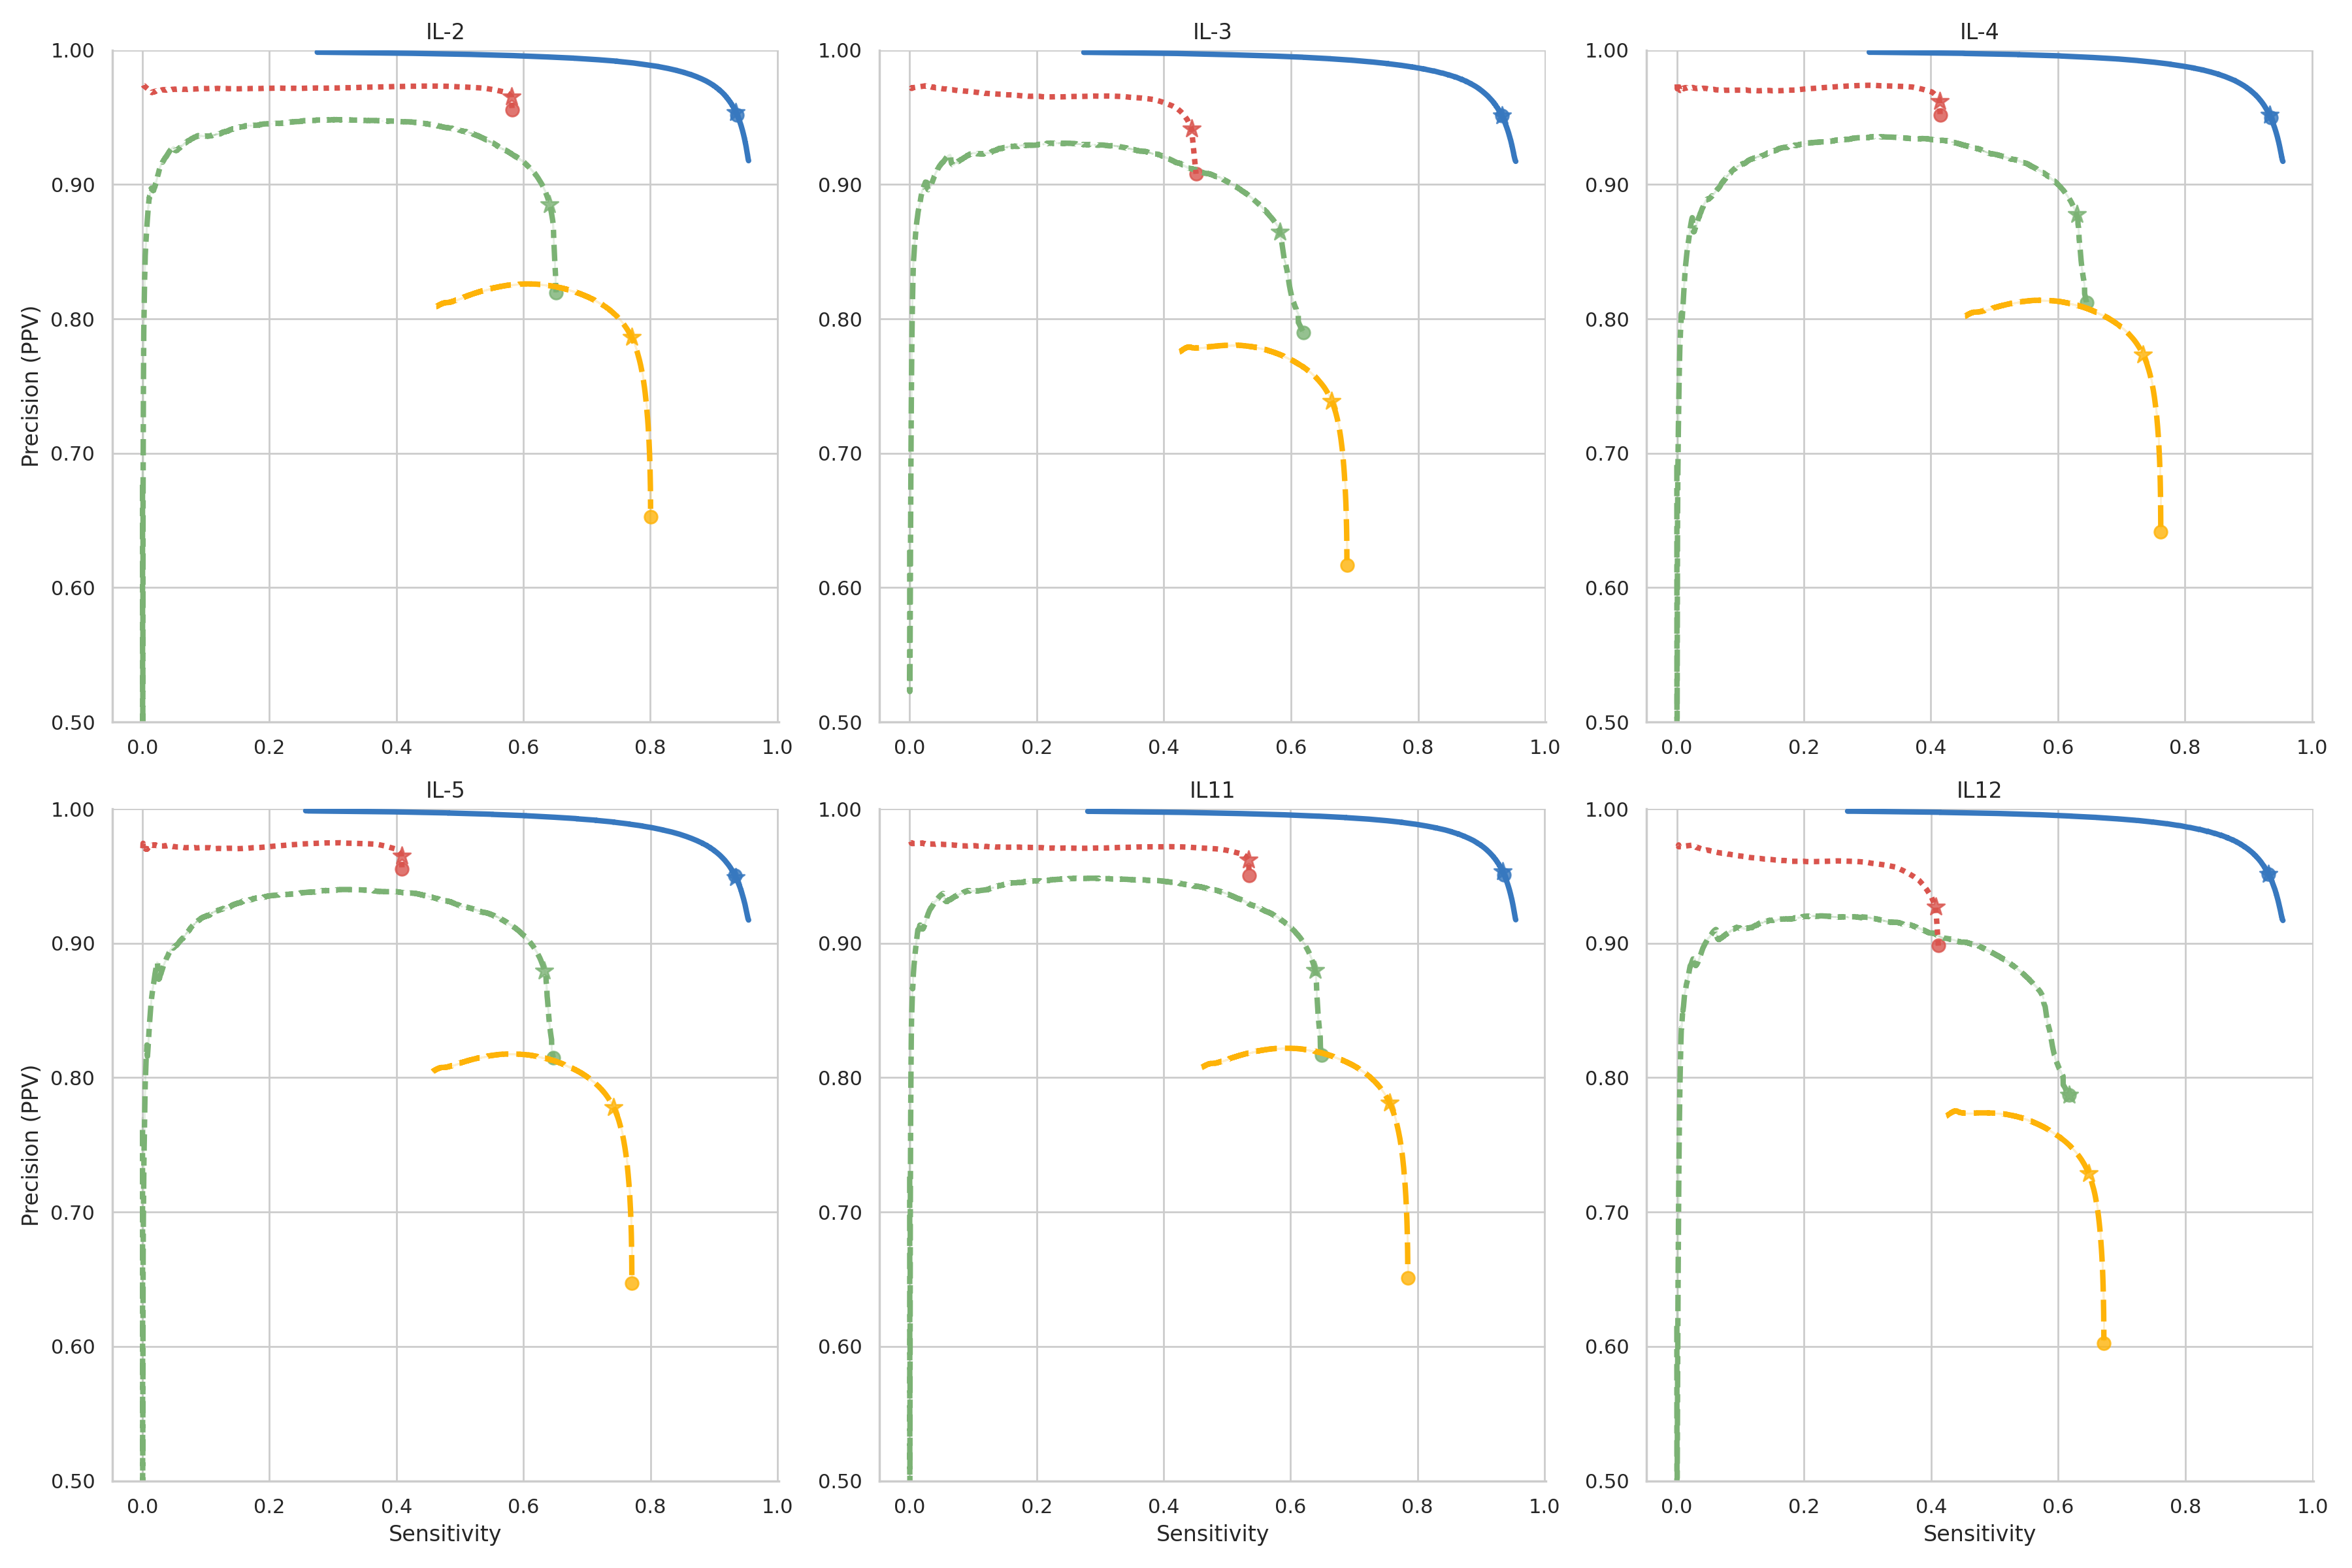

In [756]:
cells = ["IL-2", "IL-3", "IL-4", "IL-5", "IL11", "IL12"]
dfs = [filterd_rocs.query("Match=='GT' and Control=='IL1C' and Test=='" + cell + "'") for cell in cells]
plot_precision_recalls(dfs, titles=cells, ncols=3,
                       linewidth=3,
                       y_format='%.2f',
                       ylims=(.5, 1.),
                       marker_scores=caller_pass_scores,
                       optimal_marker_scores=True,
                       save = figure_dir / "dong_precision_recalls.pdf")

In [ ]:
indel_stats = read_indel_size_distributions(experiments)

In [23]:
indel_stats

Control  Test             Group  Filtered Match   Caller  size  count
0      Hunamp  IL-2  clones_and_cells      True    GT  Octopus   -49     36
1      Hunamp  IL-2  clones_and_cells      True    GT  Octopus   -48     76
2      Hunamp  IL-2  clones_and_cells      True    GT  Octopus   -47     32
3      Hunamp  IL-2  clones_and_cells      True    GT  Octopus   -46     53
4      Hunamp  IL-2  clones_and_cells      True    GT  Octopus   -45     51
...       ...   ...               ...       ...   ...      ...   ...    ...
15705    IL1C  IL12  clones_and_cells     False    AL  Prosolo    33      1
15706    IL1C  IL12  clones_and_cells     False    AL  Prosolo    34      1
15707    IL1C  IL12  clones_and_cells     False    AL  Prosolo    35      0
15708    IL1C  IL12  clones_and_cells     False    AL  Prosolo    36      0
15709    IL1C  IL12  clones_and_cells     False    AL  Prosolo    37      1

[15710 rows x 8 columns]

In [289]:
indel_stats.query("Filtered and Control=='IL1C' and Match=='GT'").groupby(["Caller"]).agg({"count": "sum"})

count
Caller           
Octopus   4417551
SCcaller   891310

In [291]:
indel_stats.query("Filtered and Control=='IL1C' and Match=='GT' and size>0").groupby(["Caller"]).agg({"count": "sum"})

count
Caller           
Octopus   2138137
SCcaller   381354

In [292]:
indel_stats.query("Filtered and Control=='IL1C' and Match=='GT' and size<0").groupby(["Caller"]).agg({"count": "sum"})

count
Caller           
Octopus   2279414
SCcaller   509956

In [290]:
summary_df.query("Filtered and Control=='IL1C' and Match=='GT'").groupby(["Caller"]).agg({"True-pos-baseline": "sum"})

True-pos-baseline
Caller                     
Octopus            25589057
SCcaller           12451104

In [293]:
indel_stats.query("Filtered and Control=='IL1C' and Match=='AL'").groupby(["Caller"]).agg({"count": "sum"})

count
Caller           
Octopus   4552634
SCcaller  1252903

<IPython.core.display.Javascript object>


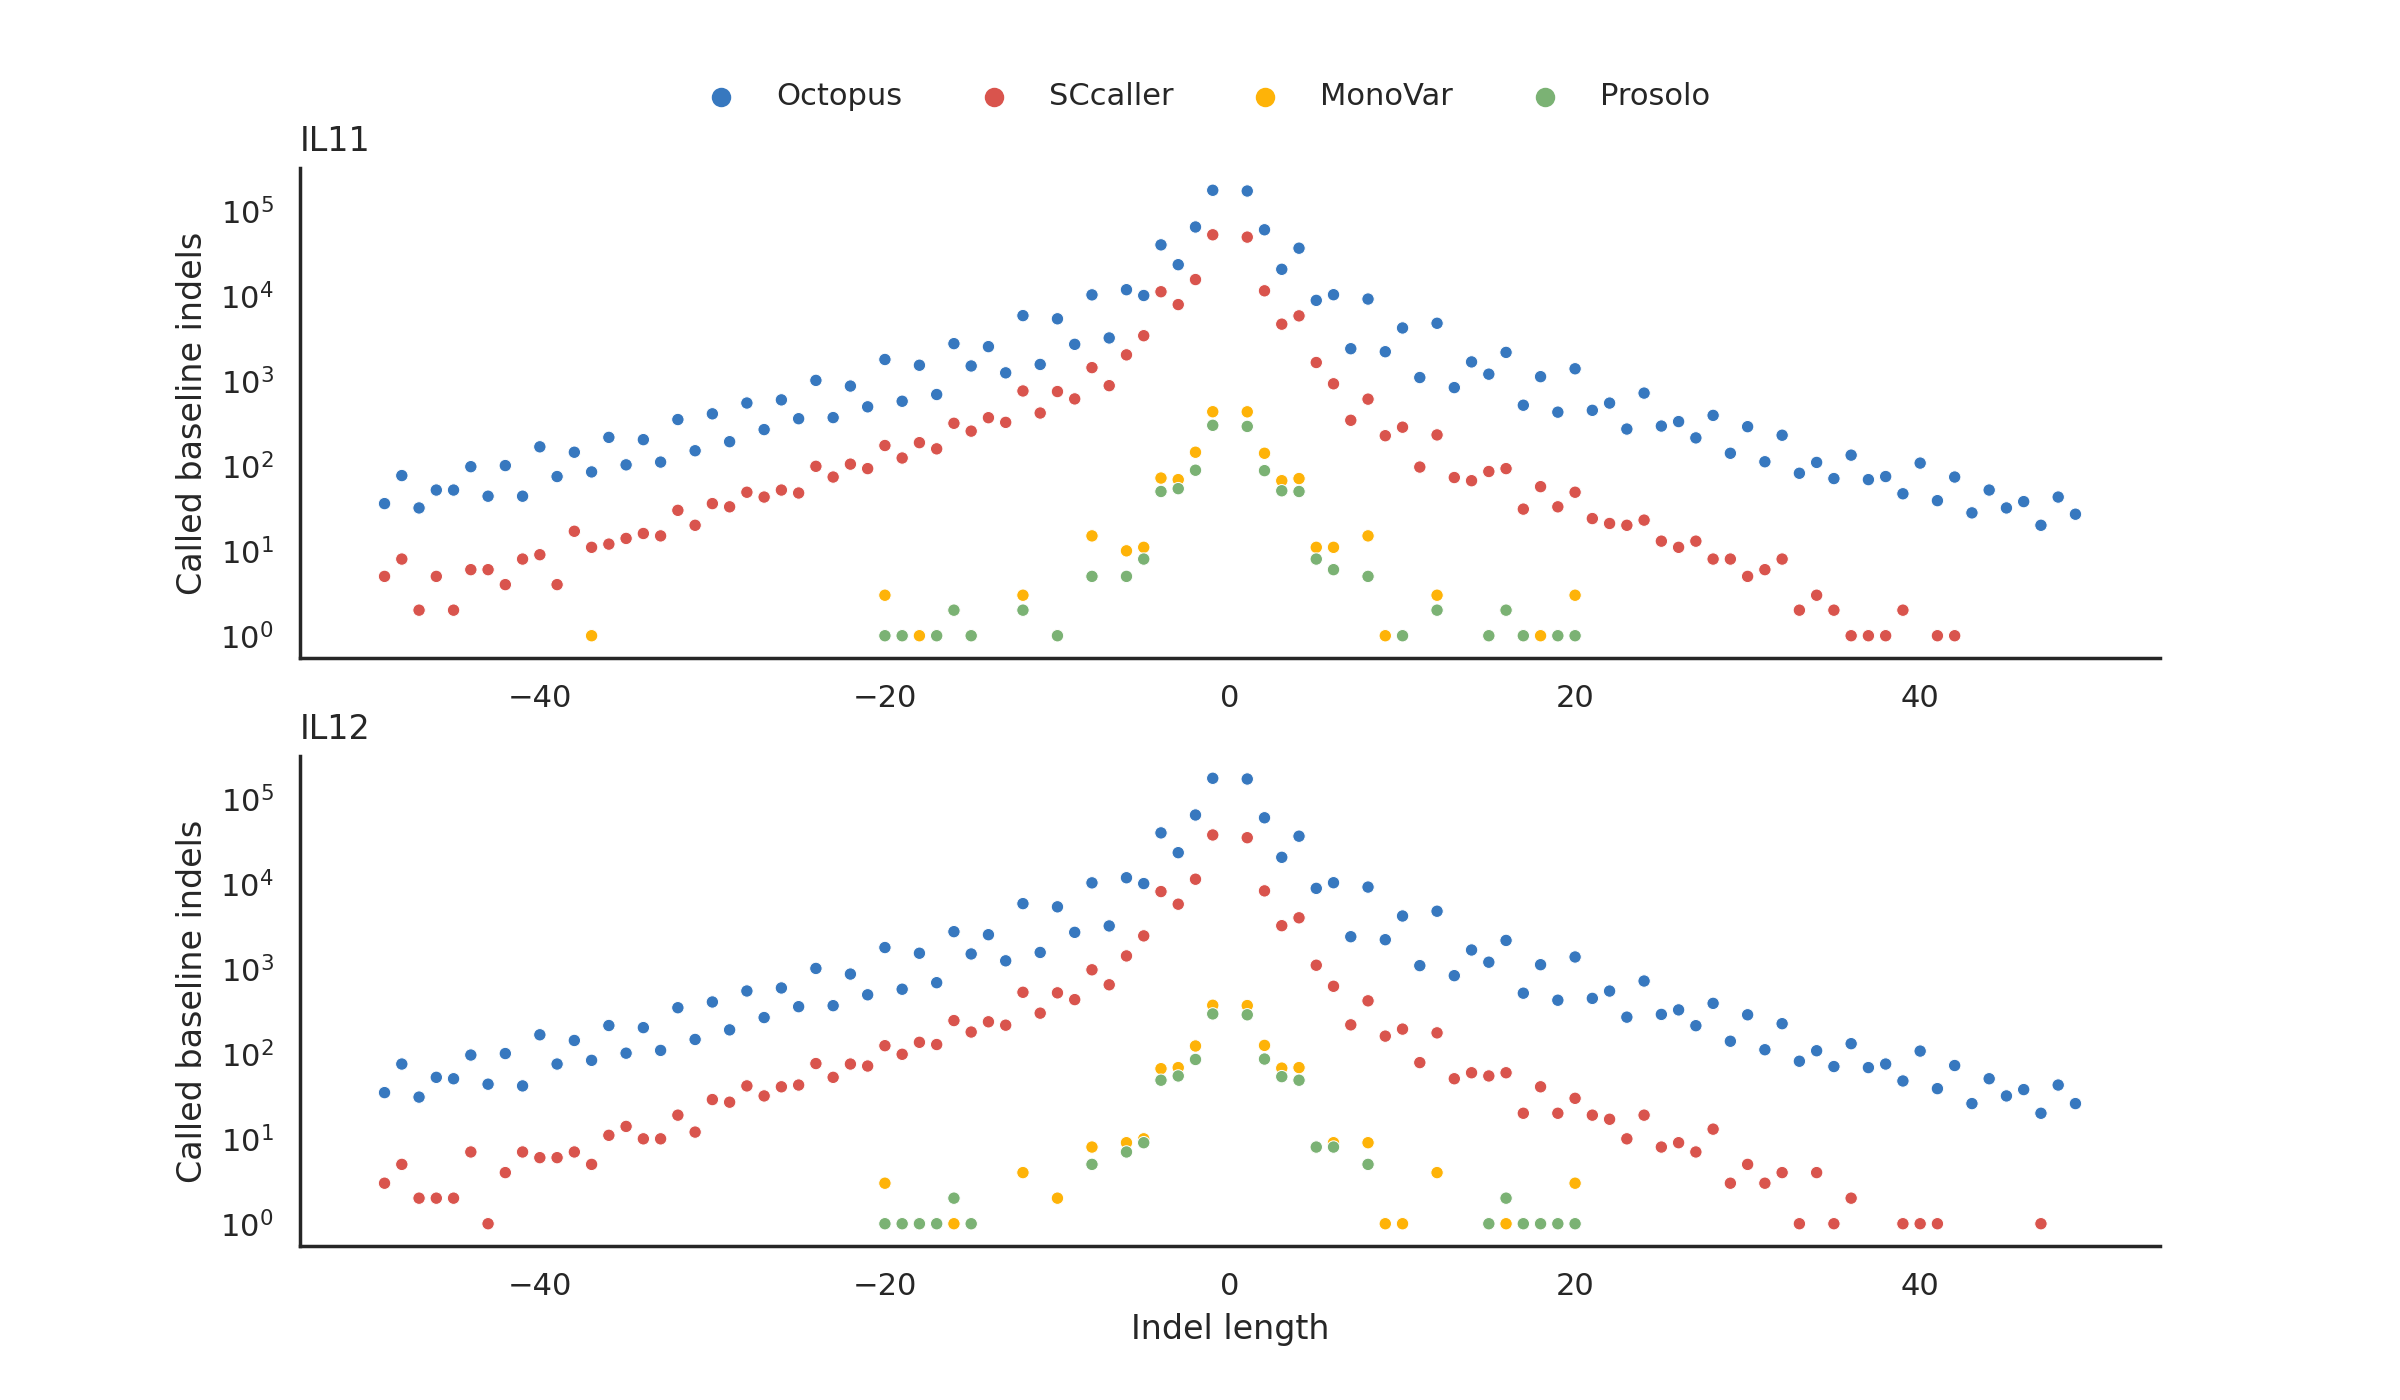

In [757]:
sns.set(style="white")
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 7))
df = indel_stats.query("Filtered and Match=='GT' and Control=='IL1C' and Test=='IL11' and count>0").copy()
sns.scatterplot(x="size", y="count",
                hue="Caller", 
                hue_order=list(reversed(caller_order)),
                palette=caller_colours,
                s=20, marker="o",
                data=df,
                ax=axes[0])
df = indel_stats.query("Filtered and Match=='GT' and Control=='IL1C' and Test=='IL12' and count>0").copy()
sns.scatterplot(x="size", y="count",
                hue="Caller", 
                hue_order=list(reversed(caller_order)),
                palette=caller_colours,
                s=20, marker="o",
                data=df,
                ax=axes[1])
sns.despine(ax=axes[0])
sns.despine(ax=axes[1])
handles, labels = axes[0].get_legend_handles_labels()
lgd = fig.legend(handles=reversed(handles), labels=reversed(labels),
                 frameon=False, loc='upper center',
                 bbox_to_anchor=(0.5, 0.95),
                 borderaxespad=0,
                 ncol=len(labels))
axes[0].set_title('IL11', loc='left')
axes[1].set_title('IL12', loc='left')
axes[0].set_yscale('log')
axes[1].set_yscale('log')
axes[0].set(ylabel='Called baseline indels')
axes[1].set(ylabel='Called baseline indels')
axes[0].set(xlabel='')
axes[1].set(xlabel='Indel length')
axes[0].legend_.remove()
axes[1].legend_.remove()
# plt.tight_layout()
plt.savefig(figure_dir / "dong_indel_sizes.pdf",
            format='pdf', 
            transparent=True,
            bbox_extra_artists=[lgd],
            bbox_inches='tight')

In [75]:
def find_experiment(experiments, control, test):
    for experiment in experiments:
        if experiment["control"] == control and experiment["test"] == test:
            return experiment
    return None

In [25]:
e1 = find_experiment(experiments, "IL1C", "IL11")
e2 = find_experiment(experiments, "IL1C", "IL12")
vaf_df = read_vaf_distributions([e1, e2])

NameError: name 'find_experiment' is not defined

<IPython.core.display.Javascript object>


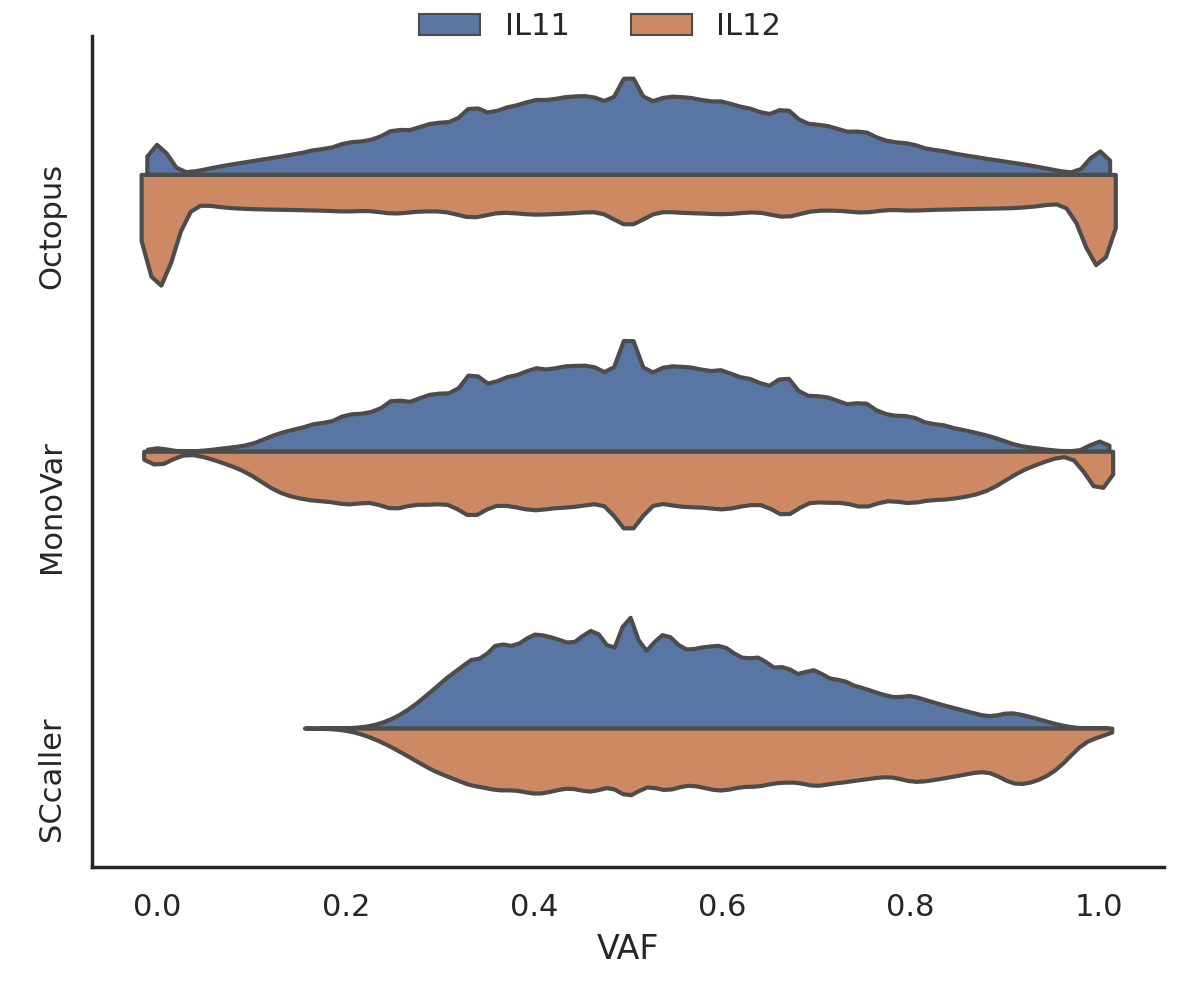

In [28]:
tp_vaf_df = vaf_df.query("Filtered and Match=='GT' and Kind=='TP' and Caller!='Prosolo'")
sns.set(style="white")
fig, ax = plt.subplots(figsize=(6, 5))
g = sns.violinplot(x="VAF",  y="Caller",
                   hue="Test",
                   split=True,
                   cut=True,
                   inner=None,
                   data=tp_vaf_df,
                   ax=ax)
sns.despine(ax=ax)
ax.set(ylabel='')
plt.yticks(rotation=90)
handles, labels = ax.get_legend_handles_labels()
lgd = fig.legend(handles=handles, labels=labels, frameon=False,
                 loc='upper center', #bbox_to_anchor=(0.5, .95),
                 borderaxespad=0, ncol=len(labels))
ax.legend_.remove()
plt.tight_layout()
plt.savefig(figure_dir / "dong_vaf_dist.pdf", format="pdf", transparent=True, bbox_inches='tight')

<IPython.core.display.Javascript object>


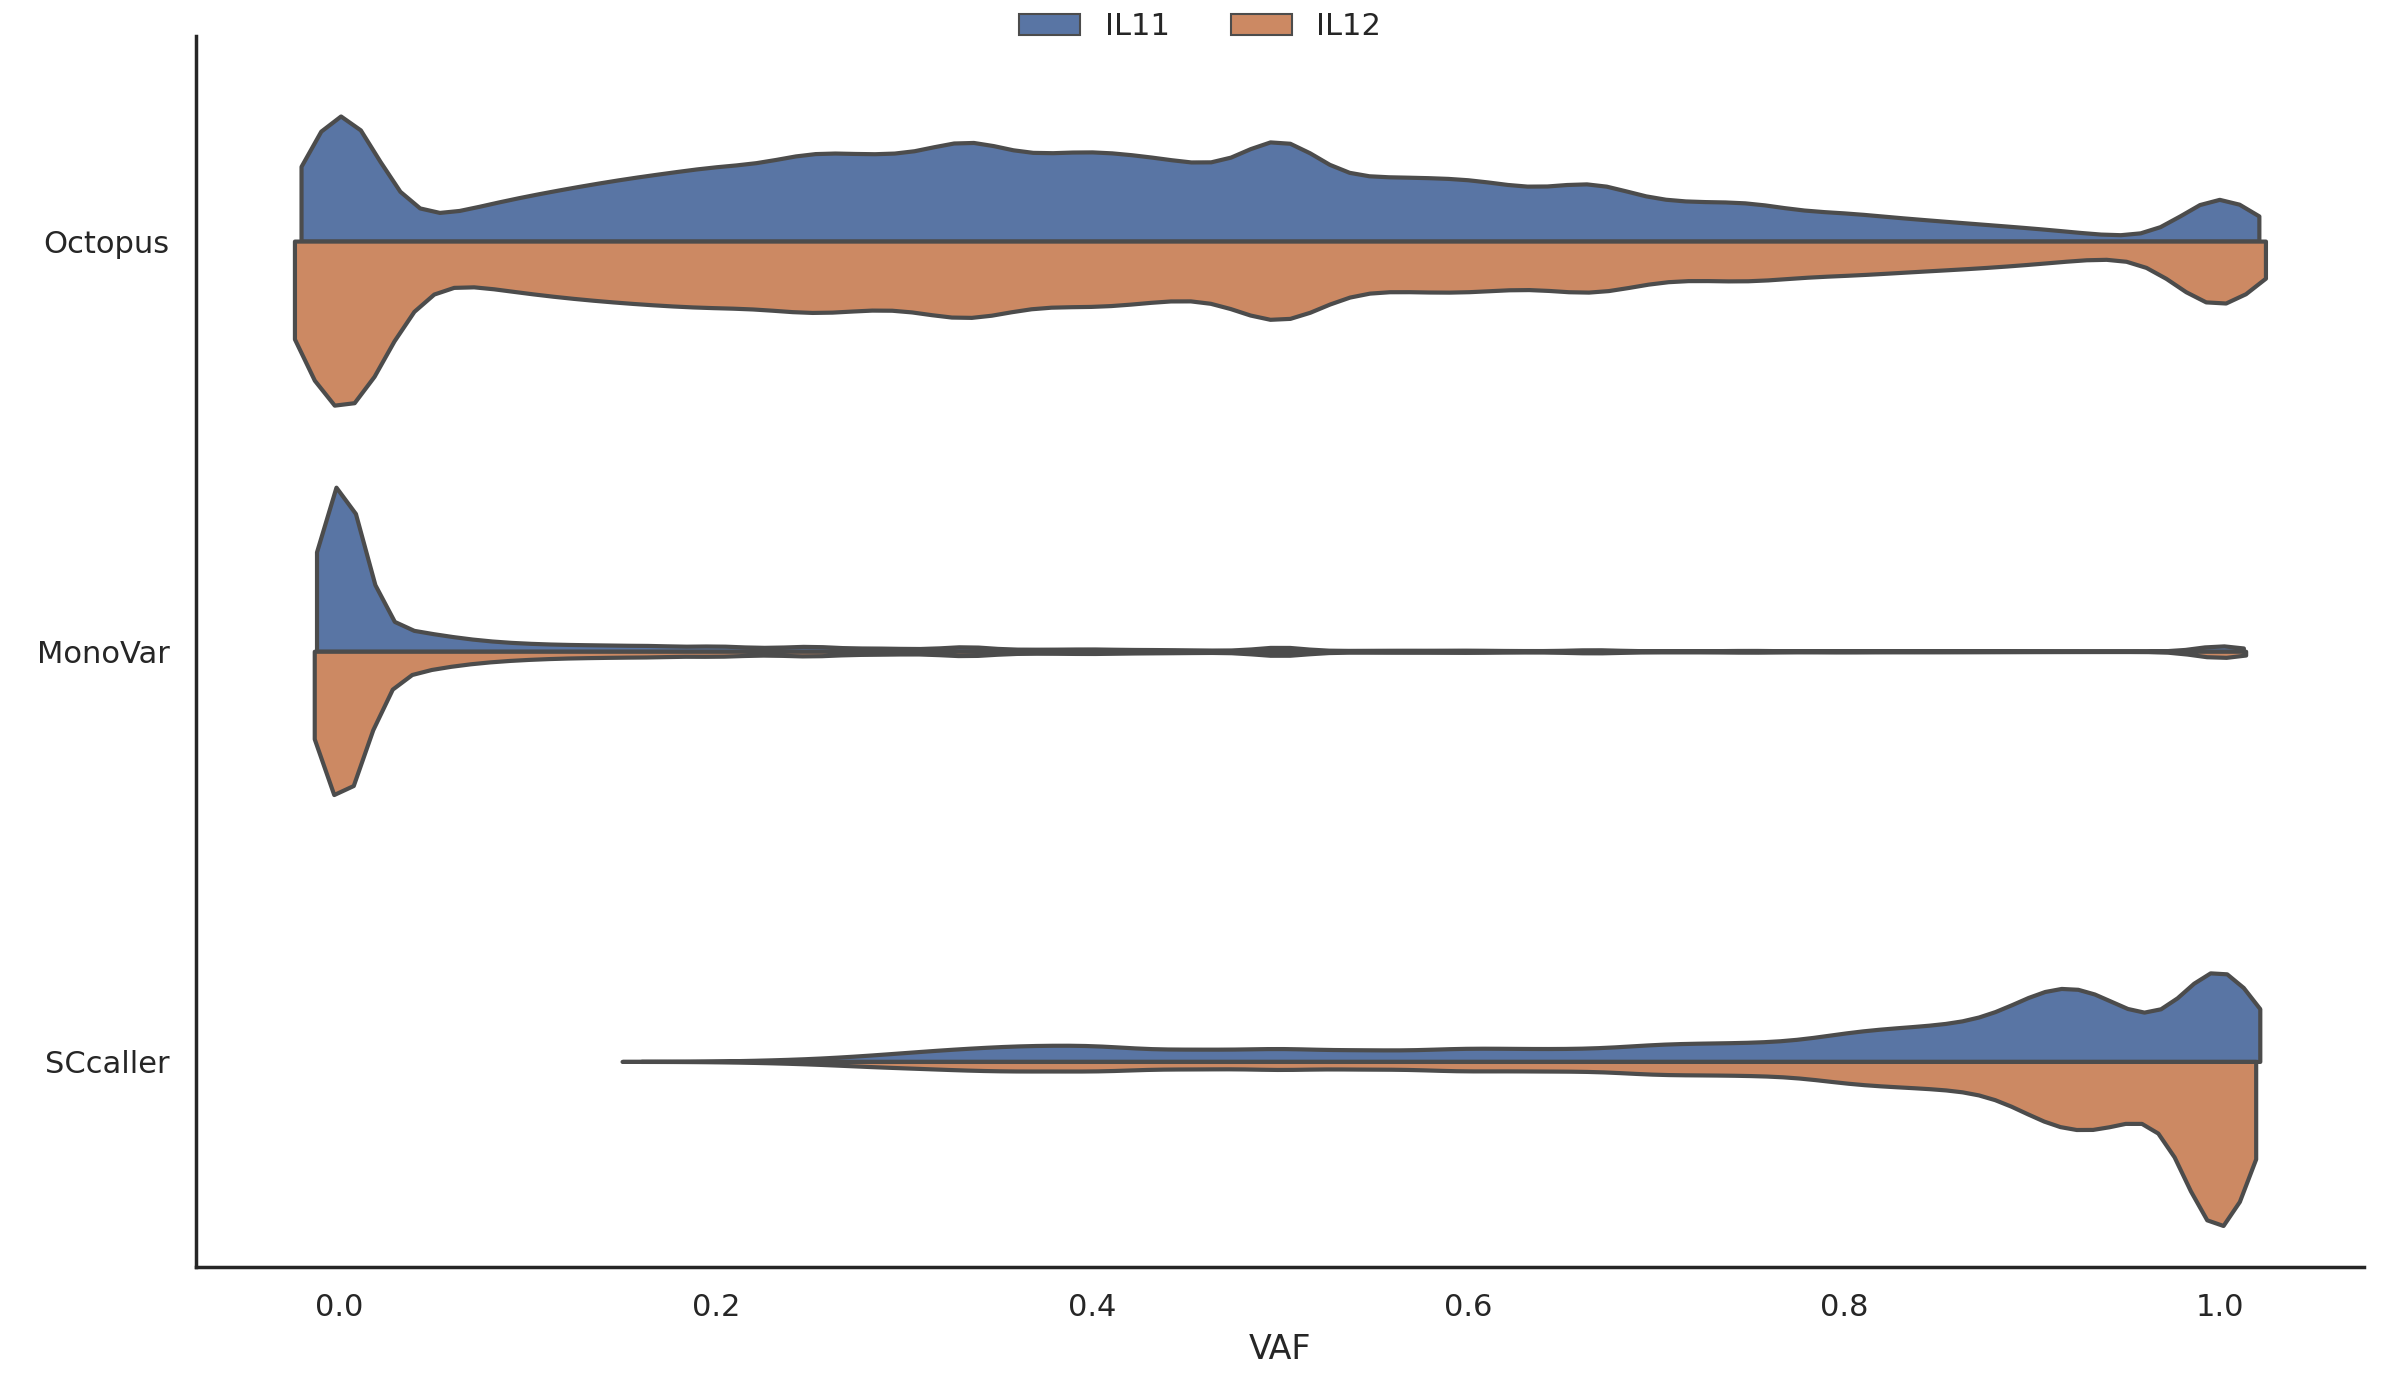

In [106]:
fp_vaf_df = vaf_df.query("Filtered and Match=='GT' and Kind=='FP' and Caller!='Prosolo'")
sns.set(style="white")
fig, ax = plt.subplots(figsize=(12, 7))
g = sns.violinplot(x="VAF",  y="Caller",
                   hue="Test",
                   split=True,
                   cut=True,
                   inner=None,
                   data=fp_vaf_df,
                   ax=ax)
sns.despine(ax=ax)
ax.set(ylabel='')
handles, labels = ax.get_legend_handles_labels()
lgd = fig.legend(handles=handles, labels=labels, frameon=False,
                 loc='upper center', #bbox_to_anchor=(0.5, .95),
                 borderaxespad=0, ncol=len(labels))
ax.legend_.remove()
plt.tight_layout()

In [785]:
from collections import defaultdict

def default_pass_condition(rec):
    return len(rec.filter) == 0 or "PASS" in rec.filter

def intersect_samples(vcf_filename, samples=None, genotypes=True, fold=True, is_pass=default_pass_condition):
    vcf = ps.VariantFile(vcf_filename)
    if samples is None:
        samples = list(vcf.header.samples)
    intsersections = defaultdict(int)
    missing = defaultdict(int)
    for rec in vcf:
        if is_pass(rec):
            assignments = defaultdict(list)
            missing_samples = []
            for sample in samples:
                if not all(a is None for a in rec.samples[sample].alleles):
                    if genotypes:
                        assignments[rec.samples[sample]["GT"]].append(sample)
                    else:
                        assignments[tuple(set(rec.samples[sample]["GT"]) - set([0]))].append(sample)
                else:
                    missing_samples.append(samples)
            if len(assignments) > 0:
                if fold:
                    key = tuple(min(assignments.items(), key=lambda x: len(x[1]))[1])
                    intsersections[key] += 1
                    if len(missing_samples) > 0:
                        missing[key] += 1
                else:
                    for _, assigned_samples in assignments.items():
                        intsersections[tuple(assigned_samples)] += 1
                        if len(missing_samples) > 0:
                            missing[tuple(assigned_samples)] += 1
    data = []
    for sample_set, count in intsersections.items():
        labels = [sample in sample_set for sample in samples]
        missing_count = missing[sample_set] if sample_set in missing else 0
        data.append(labels + [sum(labels), count, missing_count])
    return pd.DataFrame(data, columns=samples + ["Cells", "Count", "Missing"])

In [969]:
dong_cell_names = ["IL-2", "IL-3", "IL-4", "IL-5", "IL11", "IL12"]

dfs = []
for caller in ["Octopus", "SCcaller", "MonoVar", "Prosolo"]:
    caller_vcf = calls_dir["Dong"] / ("clones_and_cells.hs38DH.bwa." + caller + ".vcf.gz")
    if caller_vcf.exists():
        isecs = intersect_samples(caller_vcf, samples=dong_cell_names)
        isecs["Caller"] = caller
        isecs["Match"] = "GT"
        allele_isecs = intersect_samples(caller_vcf, samples=dong_cell_names, genotypes=False)
        allele_isecs["Caller"] = caller
        allele_isecs["Match"] = "AL"
        dfs += [isecs, allele_isecs]
dong_isecs_df = pd.concat(dfs)

In [972]:
dong_isecs_df

IL-2   IL-3   IL-4   IL-5   IL11   IL12  Cells    Count  Missing  \
0    True   True   True   True   True   True      6  4688944        0   
1   False  False  False  False  False   True      1    10252        0   
2    True  False  False  False   True  False      2     1547        0   
3    True  False  False  False   True   True      3     1404        0   
4   False  False  False   True  False  False      1     4999        0   
..    ...    ...    ...    ...    ...    ...    ...      ...      ...   
58  False   True   True  False  False   True      3    27244    27244   
59   True   True   True   True  False  False      4    31051    31051   
60  False   True   True  False   True  False      3    25529    25529   
61  False   True  False   True   True  False      3    25109    25109   
62   True  False   True   True   True   True      5    40630    40630   

     Caller Match  
0   Octopus    GT  
1   Octopus    GT  
2   Octopus    GT  
3   Octopus    GT  
4   Octopus    GT  
..      ...   ...  
58  Prosolo    AL  
59  Prosolo    AL  
60  Prosolo    AL  
61  Prosolo    AL  
62  Prosolo    AL  

[442 rows x 11 columns]

In [1009]:
dong_agg_isecs_df = dong_isecs_df.groupby(["Caller", "Match", "Cells"]).aggregate({"Count": "sum", "Missing": "sum"}).reset_index()

In [1010]:
dong_agg_isecs_df

Caller Match  Cells    Count  Missing
0    MonoVar    AL      1  1466789   174572
1    MonoVar    AL      2   662016    99637
2    MonoVar    AL      3   224360    22132
3    MonoVar    AL      4    30580    30580
4    MonoVar    AL      5   206892   206892
5    MonoVar    AL      6  3956223        0
6    MonoVar    GT      1  2115535   202357
7    MonoVar    GT      2   845841   108644
8    MonoVar    GT      3   285222    21444
9    MonoVar    GT      4    27923    27923
10   MonoVar    GT      5   173445   173445
11   MonoVar    GT      6  3098894        0
12   Octopus    AL      1    28702        0
13   Octopus    AL      2    22450        0
14   Octopus    AL      3    10957        0
15   Octopus    AL      6  4705866        0
16   Octopus    GT      1    37709        0
17   Octopus    GT      2    27889        0
18   Octopus    GT      3    13433        0
19   Octopus    GT      6  4688944        0
20   Prosolo    AL      1   510634   184871
21   Prosolo    AL      2   457680   319805
22   Prosolo    AL      3   561676   505682
23   Prosolo    AL      4   470719   470719
24   Prosolo    AL      5   246529   246529
25   Prosolo    AL      6  2284112        0
26   Prosolo    GT      1   808493   280123
27   Prosolo    GT      2   510144   322959
28   Prosolo    GT      3   549504   477490
29   Prosolo    GT      4   431748   431748
30   Prosolo    GT      5   215286   215286
31   Prosolo    GT      6  2016175        0
32  SCcaller    AL      1  1125191  1029769
33  SCcaller    AL      2   460074   427843
34  SCcaller    AL      3   442251   435405
35  SCcaller    AL      4   562045   562045
36  SCcaller    AL      5   667212   667212
37  SCcaller    AL      6   595867        0
38  SCcaller    GT      1  1401825  1232638
39  SCcaller    GT      2   478232   432173
40  SCcaller    GT      3   405217   391832
41  SCcaller    GT      4   492336   492336
42  SCcaller    GT      5   573295   573295
43  SCcaller    GT      6   501735        0

<IPython.core.display.Javascript object>


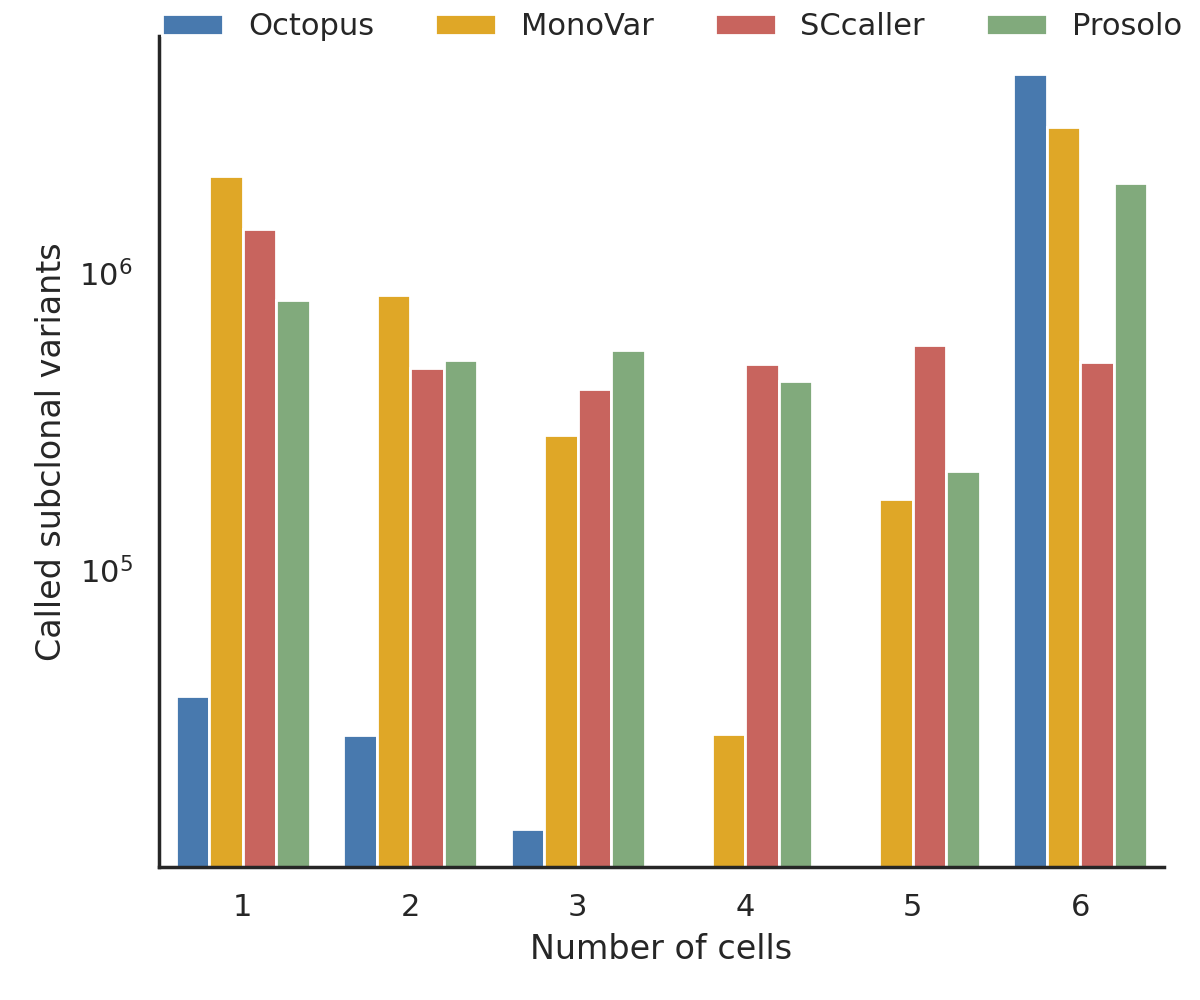

In [1012]:
sns.set(style="white")
fig, ax = plt.subplots(figsize=(6, 5))
g = sns.barplot(x="Cells", y="Count", 
                hue="Caller",
                hue_order=["Octopus", "MonoVar", "SCcaller", "Prosolo"],
                palette=caller_colours, ci=None,
                data=dong_agg_isecs_df.query("Match=='GT'"),
                ax=ax)
sns.despine(ax=ax)
ax.set_yscale('log')
ax.set(xlabel='Number of cells', ylabel='Called subclonal variants')
handles, labels = ax.get_legend_handles_labels()
lgd = fig.legend(handles=handles, labels=labels, frameon=False,
                 loc='upper center', 
                 bbox_to_anchor=(0.56, 1.),
                 borderaxespad=0, ncol=len(labels))
ax.legend_.remove()
plt.tight_layout()
plt.savefig(figure_dir / "dong_isec_summary.pdf", format="pdf", transparent=True, bbox_inches='tight')

In [40]:
def report_subclonal(agg_isecs_df, caller, match="GT"):
    df = agg_isecs_df.query("Caller=='" + caller + "' and Match=='" + match + "'")
    subclonal, total = int(df.query("Cells<6")["Count"].sum()), df["Count"].sum()
    return subclonal, total, subclonal / total

def report_subclonal_missing(agg_isecs_df, caller, match="GT"):
    df = agg_isecs_df.query("Caller=='" + caller + "' and Match=='" + match + "'")
    subclonal, total = int(df.query("Cells<6")["Missing"].sum()), df.query("Cells<6")["Count"].sum()
    return subclonal, total, subclonal / total

In [484]:
report_subclonal(dong_agg_isecs_df, "Octopus")

(79031, 4767975, 0.01657538053366471)

In [485]:
report_subclonal(dong_agg_isecs_df, "Prosolo")

(2515175, 4531350, 0.5550608538294327)

In [41]:
report_subclonal(dong_agg_isecs_df, "SCcaller")

(3350905, 3852640, 0.8697685223638856)

In [42]:
report_subclonal_missing(dong_agg_isecs_df, "SCcaller")

(3122274, 3350905, 0.931770372481464)

In [43]:
report_subclonal(dong_agg_isecs_df, "MonoVar")

(3447966, 6546860, 0.5266594978356036)

In [482]:
report_subclonal_missing(dong_agg_isecs_df, "MonoVar")

(533813, 3447966, 0.15481968209663322)

In [486]:
report_subclonal_missing(dong_agg_isecs_df, "Prosolo")

(1727606, 2515175, 0.6868730804019602)

In [79]:
sns.color_palette()

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

In [992]:
def get_upsetr_input(isecs, cells, caller, match="GT"):
    isecs = isecs.query("Match=='" + match + "' and Caller=='" + caller + "'")[cells + ["Count"]]
    items = []
    for _, row in isecs.iterrows():
        labels = []
        for sample, present in zip(isecs.columns[:-1], row):
            if present: labels.append(sample)
        items.append("'" + '&'.join(labels) + "'=" + str(row[-1]))
    return ','.join(items)

def get_upsetr_query(isecs, cells, caller, match="GT", colours=None):
    isecs = isecs.query("Match=='" + match + "' and Caller=='" + caller + "'")[cells + ["Count"]]
    if colours is None:
        palette = sns.color_palette().as_hex()
        colours = {
            1: palette[3],
            2: palette[4],
            3: palette[0],
            4: palette[5],
            5: palette[1],
            6: palette[2]
        }
    queries = []
    for _, row in isecs.iterrows():
        labels = []
        for sample, present in zip(isecs.columns[:-1], row):
            if present: labels.append('"' + sample + '"')
        queries.append('list(query = intersects, params = list(' + ','.join(labels) + '), active = T, color = "' + colours[len(labels)] + '")')
    return "list(" + ','.join(queries) + ")"

In [998]:
get_upsetr_input(dong_isecs_df, dong_cell_names, caller="Prosolo")

"'IL-2&IL-3'=31107,'IL-2&IL-3&IL-4&IL-5&IL11&IL12'=2016175,'IL-5'=100278,'IL-4&IL-5'=35068,'IL-3&IL-4'=36524,'IL-3&IL-4&IL11&IL12'=29170,'IL-2&IL-5&IL11'=30582,'IL-2'=67536,'IL-2&IL-4&IL-5&IL11'=28183,'IL12'=235798,'IL-3'=223269,'IL-4'=106832,'IL-5&IL12'=36656,'IL-3&IL-5'=35152,'IL11'=74780,'IL-2&IL-4'=30351,'IL-2&IL-4&IL-5'=30577,'IL-2&IL-5'=30590,'IL-3&IL11'=32230,'IL-2&IL11'=29562,'IL-4&IL11'=30815,'IL-2&IL-4&IL12'=30831,'IL11&IL12'=33154,'IL-2&IL-3&IL12'=31238,'IL-2&IL-3&IL-4&IL-5&IL11'=35575,'IL-4&IL12'=37463,'IL-2&IL-3&IL-4&IL-5&IL12'=35757,'IL-3&IL-5&IL11&IL12'=29484,'IL-2&IL12'=31774,'IL-5&IL11'=30331,'IL-2&IL-3&IL11&IL12'=28431,'IL-5&IL11&IL12'=23874,'IL-2&IL-3&IL11'=30834,'IL-2&IL-5&IL12'=31029,'IL-2&IL-4&IL11'=30425,'IL-2&IL11&IL12'=31224,'IL-2&IL-3&IL-5'=29990,'IL-4&IL-5&IL11'=23700,'IL-4&IL-5&IL12'=24543,'IL-2&IL-5&IL11&IL12'=28102,'IL-2&IL-3&IL-4&IL11&IL12'=35163,'IL-2&IL-3&IL-4'=30585,'IL-3&IL12'=49367,'IL-2&IL-3&IL-4&IL11'=28007,'IL-2&IL-3&IL-4&IL12'=28869,'IL-3&IL11&IL

In [997]:
get_upsetr_query(dong_isecs_df, dong_cell_names, caller="SCcaller")

'list(list(query = intersects, params = list("IL-3","IL11"), active = T, color = "#8172b3"),list(query = intersects, params = list("IL11"), active = T, color = "#c44e52"),list(query = intersects, params = list("IL-2"), active = T, color = "#c44e52"),list(query = intersects, params = list("IL-2","IL-4"), active = T, color = "#8172b3"),list(query = intersects, params = list("IL-2","IL-3","IL11"), active = T, color = "#4c72b0"),list(query = intersects, params = list("IL12"), active = T, color = "#c44e52"),list(query = intersects, params = list("IL-2","IL11"), active = T, color = "#8172b3"),list(query = intersects, params = list("IL-4","IL12"), active = T, color = "#8172b3"),list(query = intersects, params = list("IL-5"), active = T, color = "#c44e52"),list(query = intersects, params = list("IL-2","IL-3","IL-4","IL-5","IL11","IL12"), active = T, color = "#55a868"),list(query = intersects, params = list("IL-4"), active = T, color = "#c44e52"),list(query = intersects, params = list("IL-2","I

In [1005]:
def read_subclonal(isec_dir):
    both_tp = count_records(isec_dir / "ABC.vcf.gz")
    both_fn = count_records(isec_dir / "A.vcf.gz")
    il11_tp = count_records(isec_dir / "AB.vcf.gz")
    il12_tp = count_records(isec_dir / "AC.vcf.gz")
    return pd.DataFrame([["IL11&IL12", both_tp],
                         ["IL11", il11_tp],
                         ["IL12", il12_tp], 
                         ["None", both_fn]], 
                        columns=["isec", "count"])

In [1006]:
dfs = []
for caller in ["Octopus", "SCcaller", "MonoVar", "Prosolo"]:
    isec_dir = eval_dir["Dong"] / ("clones_and_cells.hs38DH.bwa." + caller + ".pass.GT.IL1C.kindred_cells.isec")
    df = read_subclonal(isec_dir)
    df["Caller"] = caller
    df["Match"] = "GT"
    dfs.append(df)
subclone_df = pd.concat(dfs)

In [1007]:
subclone_df

isec  count    Caller Match
0  IL11&IL12     46   Octopus    GT
1       IL11      1   Octopus    GT
2       IL12      5   Octopus    GT
3       None     17   Octopus    GT
0  IL11&IL12     15  SCcaller    GT
1       IL11     20  SCcaller    GT
2       IL12     21  SCcaller    GT
3       None     13  SCcaller    GT
0  IL11&IL12     33   MonoVar    GT
1       IL11      8   MonoVar    GT
2       IL12      6   MonoVar    GT
3       None     22   MonoVar    GT
0  IL11&IL12      0   Prosolo    GT
1       IL11      0   Prosolo    GT
2       IL12      0   Prosolo    GT
3       None     69   Prosolo    GT

<IPython.core.display.Javascript object>


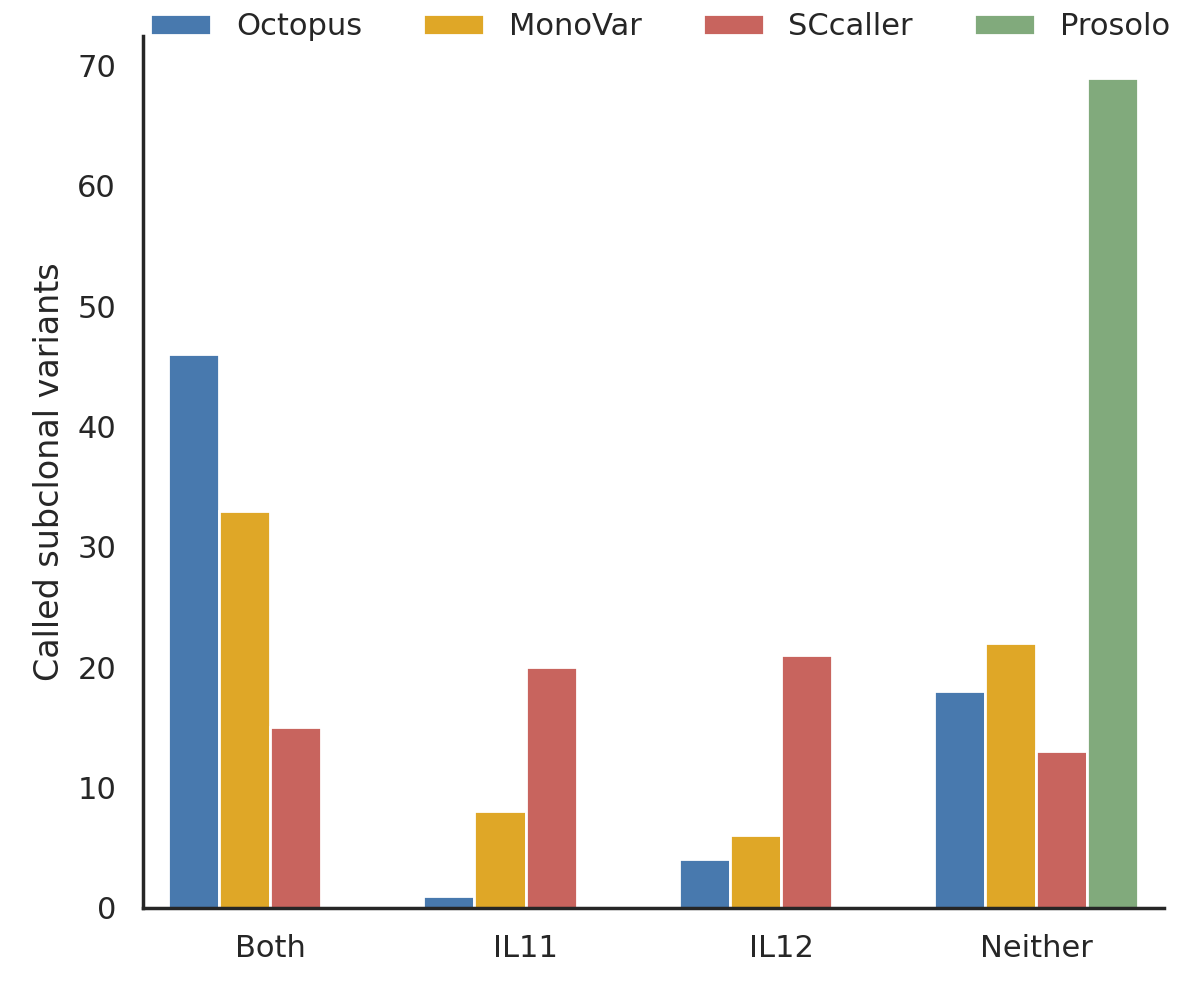

In [144]:
fig, ax = plt.subplots(figsize=(6, 5))
g = sns.barplot(x="isec", y="count",
                hue="Caller",
                hue_order=["Octopus", "MonoVar", "SCcaller", "Prosolo"],
                palette=caller_colours,
                data=subclone_df,
                ax=ax)
sns.despine(ax=ax)
ax.set(xlabel='', ylabel='Called subclonal variants')
handles, labels = ax.get_legend_handles_labels()
lgd = fig.legend(handles=handles, labels=labels, frameon=False,
                 loc='upper center', bbox_to_anchor=(0.55, 1.),
                 borderaxespad=0, ncol=len(labels))
ax.legend_.remove()
plt.tight_layout()
plt.savefig(figure_dir / "dong_subclonal.pdf", format="pdf", transparent=True, bbox_inches='tight')

<IPython.core.display.Javascript object>


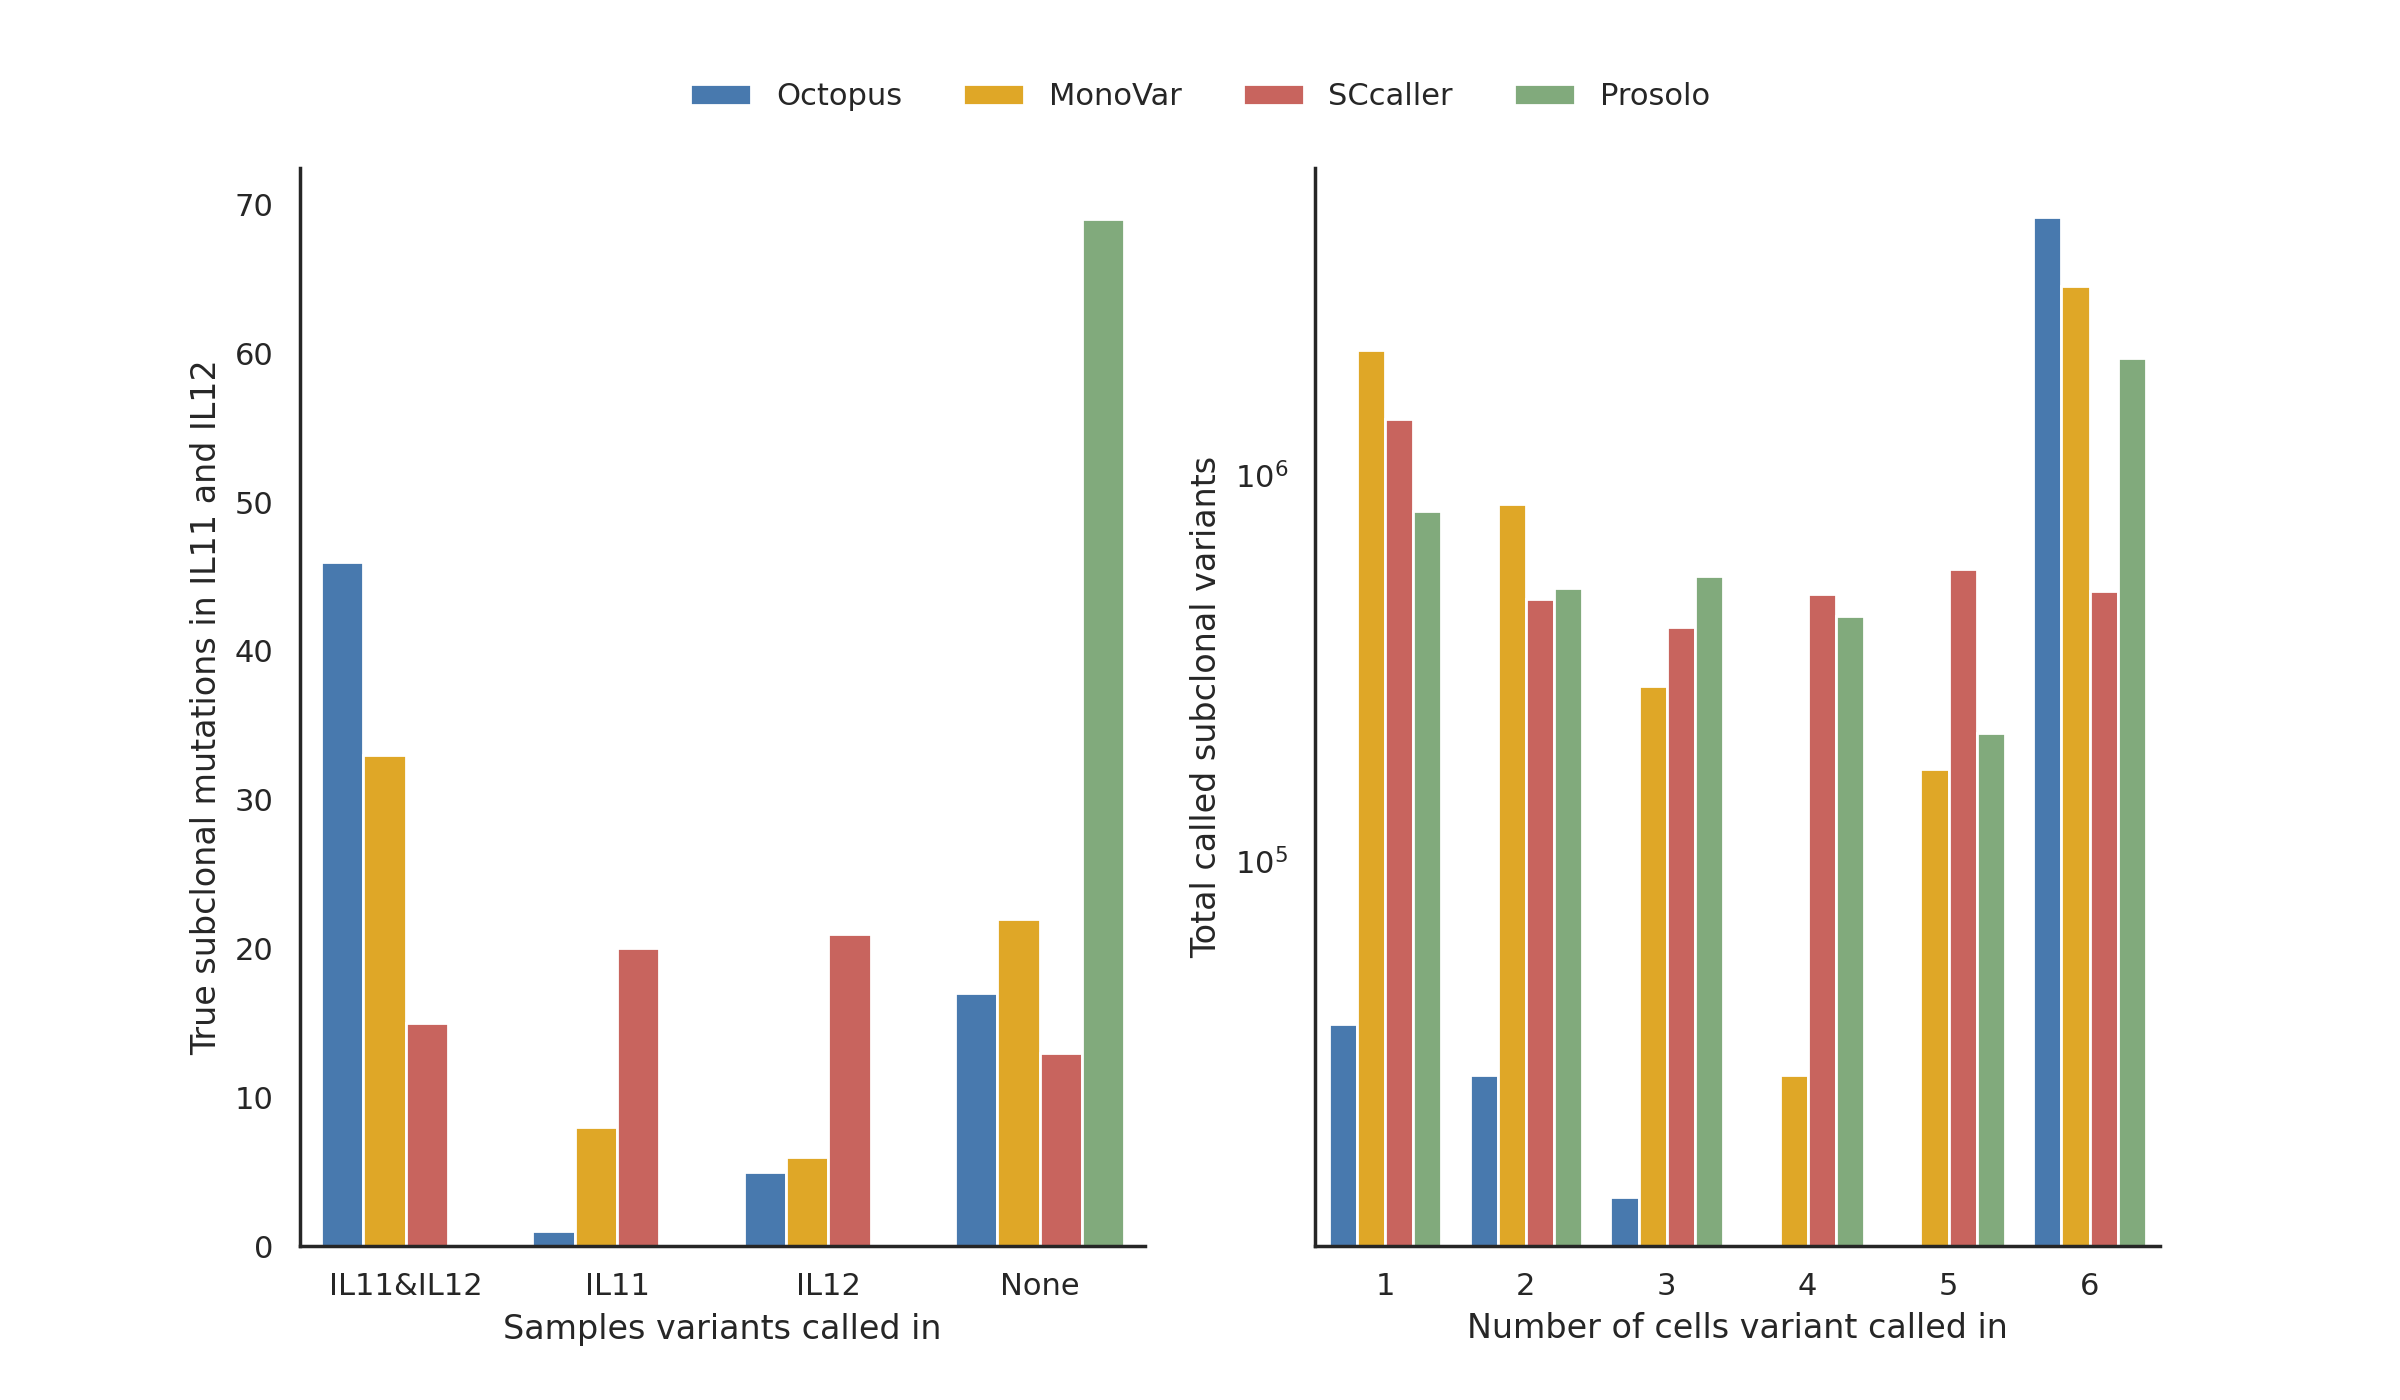

In [1019]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 7))
g = sns.barplot(x="isec", y="count",
                hue="Caller",
                hue_order=["Octopus", "MonoVar", "SCcaller", "Prosolo"],
                palette=caller_colours,
                data=subclone_df,
                ax=axes[0])
g = sns.barplot(x="Cells", y="Count", 
                hue="Caller",
                hue_order=["Octopus", "MonoVar", "SCcaller", "Prosolo"],
                palette=caller_colours, ci=None,
                data=dong_agg_isecs_df.query("Match=='GT'"),
                ax=axes[1])
sns.despine(ax=axes[0])
sns.despine(ax=axes[1])
# axes[0].set_title('True', loc='left')
# axes[1].set_title('All', loc='left')
axes[0].set(xlabel='Samples variants called in', ylabel='True subclonal mutations in IL11 and IL12')
axes[1].set_yscale('log')
axes[1].set(xlabel='Number of cells variant called in', ylabel='Total called subclonal variants')
handles, labels = axes[0].get_legend_handles_labels()
lgd = fig.legend(handles=handles, labels=labels,
                 frameon=False, loc='upper center',
                 bbox_to_anchor=(0.5, 0.95),
                 borderaxespad=0,
                 ncol=len(labels))
axes[0].legend_.remove()
axes[1].legend_.remove()
# plt.subplots_adjust(wspace=.2, hspace=0)
plt.savefig(figure_dir / "dong_subclonal.pdf",
            format='pdf', 
            transparent=True,
            bbox_extra_artists=[lgd],
            bbox_inches='tight')

In [363]:
def read_benchmark(benchmark_file):
    return pd.read_csv(benchmark_file, delimiter='\t')

In [366]:
read_benchmark(benchmark_dir / "octopus" / "clones_and_cells.hs38DH.bwa.tsv")

s             h:m:s  max_rss  max_vms  max_uss  max_pss  io_in  \
0  334551.14  3 days, 20:55:51     12.6    41.78    12.82    12.83    0.0   

   io_out  mean_load  
0     0.0        0.0

In [369]:
read_benchmark(benchmark_dir / "SCcaller" / "IL-2+clones.hs38DH.bwa.tsv")

s     h:m:s   max_rss    max_vms   max_uss   max_pss  io_in  \
0  36829.9947  10:13:49  51586.48  111209.99  51031.21  51079.53    0.0   

   io_out  mean_load  
0     0.0    1551.09

In [872]:
def phred_to_probability(phreds):
    if phreds is None: phreds = 3
    return 1 - 10**(-phreds / 10)

def encode_gt(gt, confidence=None, squash_ploidy=False):
    if squash_ploidy:
        if confidence:
            return -confidence if sum(gt) > 0 else confidence
        else:
            return 1 if gt > 0 else 0
    if any(allele is None for allele in gt):
        return 0 if confidence is None else confidence - 1
    elif all(allele == gt[0] for allele in gt):
        if gt[0] == 0:
            return 0 if confidence is None else confidence - 1
        else:
            return 2 if confidence is None else 3 + confidence
    else:
        return 1 if confidence is None else 1 + confidence

def extract_genotype_matrix(vcf_filename, samples=None, is_good_site=None, confidence=False, confidence_field="GQ", squash_ploidy=False):
    vcf = ps.VariantFile(vcf_filename)
    if samples is None:
        samples = list(vcf.header.samples)
    data = []
    for rec in vcf:
        if len(rec.alts) == 1 and (is_good_site is None or is_good_site(rec)):
            data.append([encode_gt(rec.samples[sample]["GT"], 
                                   phred_to_probability(rec.samples[sample][confidence_field]) if confidence else None,
                                   squash_ploidy=squash_ploidy
                                  )
                         for sample in samples])
    return pd.DataFrame(data, columns=samples)

In [931]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches

def draw_clustermap(genotypes, discrete=False, alleles=False, method="average",
                    linewidths=0,
                    save=None, save_format="pdf", transparent=True):
    genotype_colours = [sns.color_palette()[-3], sns.color_palette()[0], sns.color_palette()[3]]
    if discrete:
        cmap = LinearSegmentedColormap.from_list('Custom', genotype_colours, len(genotype_colours))
    else:
        grad_genotype_colours = 2 * ["white"] + sns.light_palette(genotype_colours[0], n_colors=10) + \
                                10 * ["white"] + \
                                sns.light_palette(genotype_colours[1], n_colors=10) + \
                                10 * ["white"] + \
                                sns.light_palette(genotype_colours[2], n_colors=10)
        cmap = LinearSegmentedColormap.from_list('Custom', grad_genotype_colours)
    g = sns.clustermap(genotypes,
                       dendrogram_ratio=(1e-5, 0.08),
                       edgecolor="white",
                       linewidths=linewidths,
                       linecolor='white',
                       method=method,
                       vmin=0 if discrete else -1, 
                       vmax=1 if alleles else 2 if discrete else 4,
                       cmap=cmap)
    g.ax_row_dendrogram.set_visible(False)
    g.ax_row_dendrogram.set_xlim([0,0])
    g.cax.set_visible(False)
    handles = []
    for colour, label in zip(genotype_colours, ["RR", "AR", "AA"]):
        handles.append(mpatches.Patch(color=colour, label=label))
    g.ax_col_dendrogram.legend(handles=handles, 
                               frameon=False,
                               loc='center',
                               bbox_to_anchor=(0.85, 0.99),
                               borderaxespad=0,
                               ncol=3)
    g.ax_heatmap.set_yticklabels("")
    g.ax_heatmap.set_yticks([])
    plt.tight_layout()
    if save is not None:
        plt.savefig(save, format = save_format, transparent=transparent)
    else:
        plt.show()

In [940]:
def rename_wang_samples(df):
    new_col_names = {}
    for n in range(1, 17):
        new_col_names["TNBC-n" + str(n)] = "n" + str(n)
    return df.rename(columns=new_col_names)

def extract_genotypes(genotypes, min_count=1):
    df = genotypes.copy()
    df["Count"] = df.apply(lambda row: sum(1 if a > 0 else 0 for a in row), axis=1)
    return df.query(str(min_count) + "<= Count").drop(columns=["Count"])

In [933]:
def is_pass_octopus_site(rec):
    return "PASS" in rec.filter

def is_pass_octopus_samples(rec):
    return is_pass_octopus_site(rec) and all(fields["FT"] == "PASS" for _, fields in rec.samples.items())

def is_pass_octopus_samples(rec):
    return is_pass_octopus_site(rec) and rec.info["RFGQ_ALL"] >= 4

octopus_vcf = calls_dir["Wang"] / "cells.hs38DH.bwa.Octopus.somatics.vcf.gz"
octopus_cosmic_vcf = calls_dir["Wang"] / "cells.hs38DH.bwa.Octopus.somatics.cosmic.vcf.gz"

raw_octopus_genotypes = rename_wang_samples(extract_genotype_matrix(octopus_vcf, confidence=True))
pass_octopus_genotypes = rename_wang_samples(extract_genotype_matrix(octopus_vcf, is_good_site=is_pass_octopus_site, confidence=True))
highconf_octopus_genotypes = rename_wang_samples(extract_genotype_matrix(octopus_vcf, is_good_site=is_good_octopus_site, confidence=True))
raw_octopus_cosmic_genotypes = rename_wang_samples(extract_genotype_matrix(octopus_cosmic_vcf, confidence=True))
pass_octopus_cosmic_genotypes = rename_wang_samples(extract_genotype_matrix(octopus_cosmic_vcf, is_good_site=is_pass_octopus_site, confidence=True))
highconf_octopus_cosmic_genotypes = rename_wang_samples(extract_genotype_matrix(octopus_cosmic_vcf, is_good_site=is_good_octopus_site, confidence=True))

In [880]:
pass_octopus_cosmic_alleles = rename_wang_samples(extract_genotype_matrix(octopus_cosmic_vcf, is_good_site=is_pass_octopus_site, confidence=True, squash_ploidy=True))

In [889]:
len(raw_octopus_cosmic_genotypes), len(raw_octopus_genotypes)

(6529, 163957)

In [950]:
len(extract_genotypes(pass_octopus_cosmic_genotypes, 2))

3409

<IPython.core.display.Javascript object>


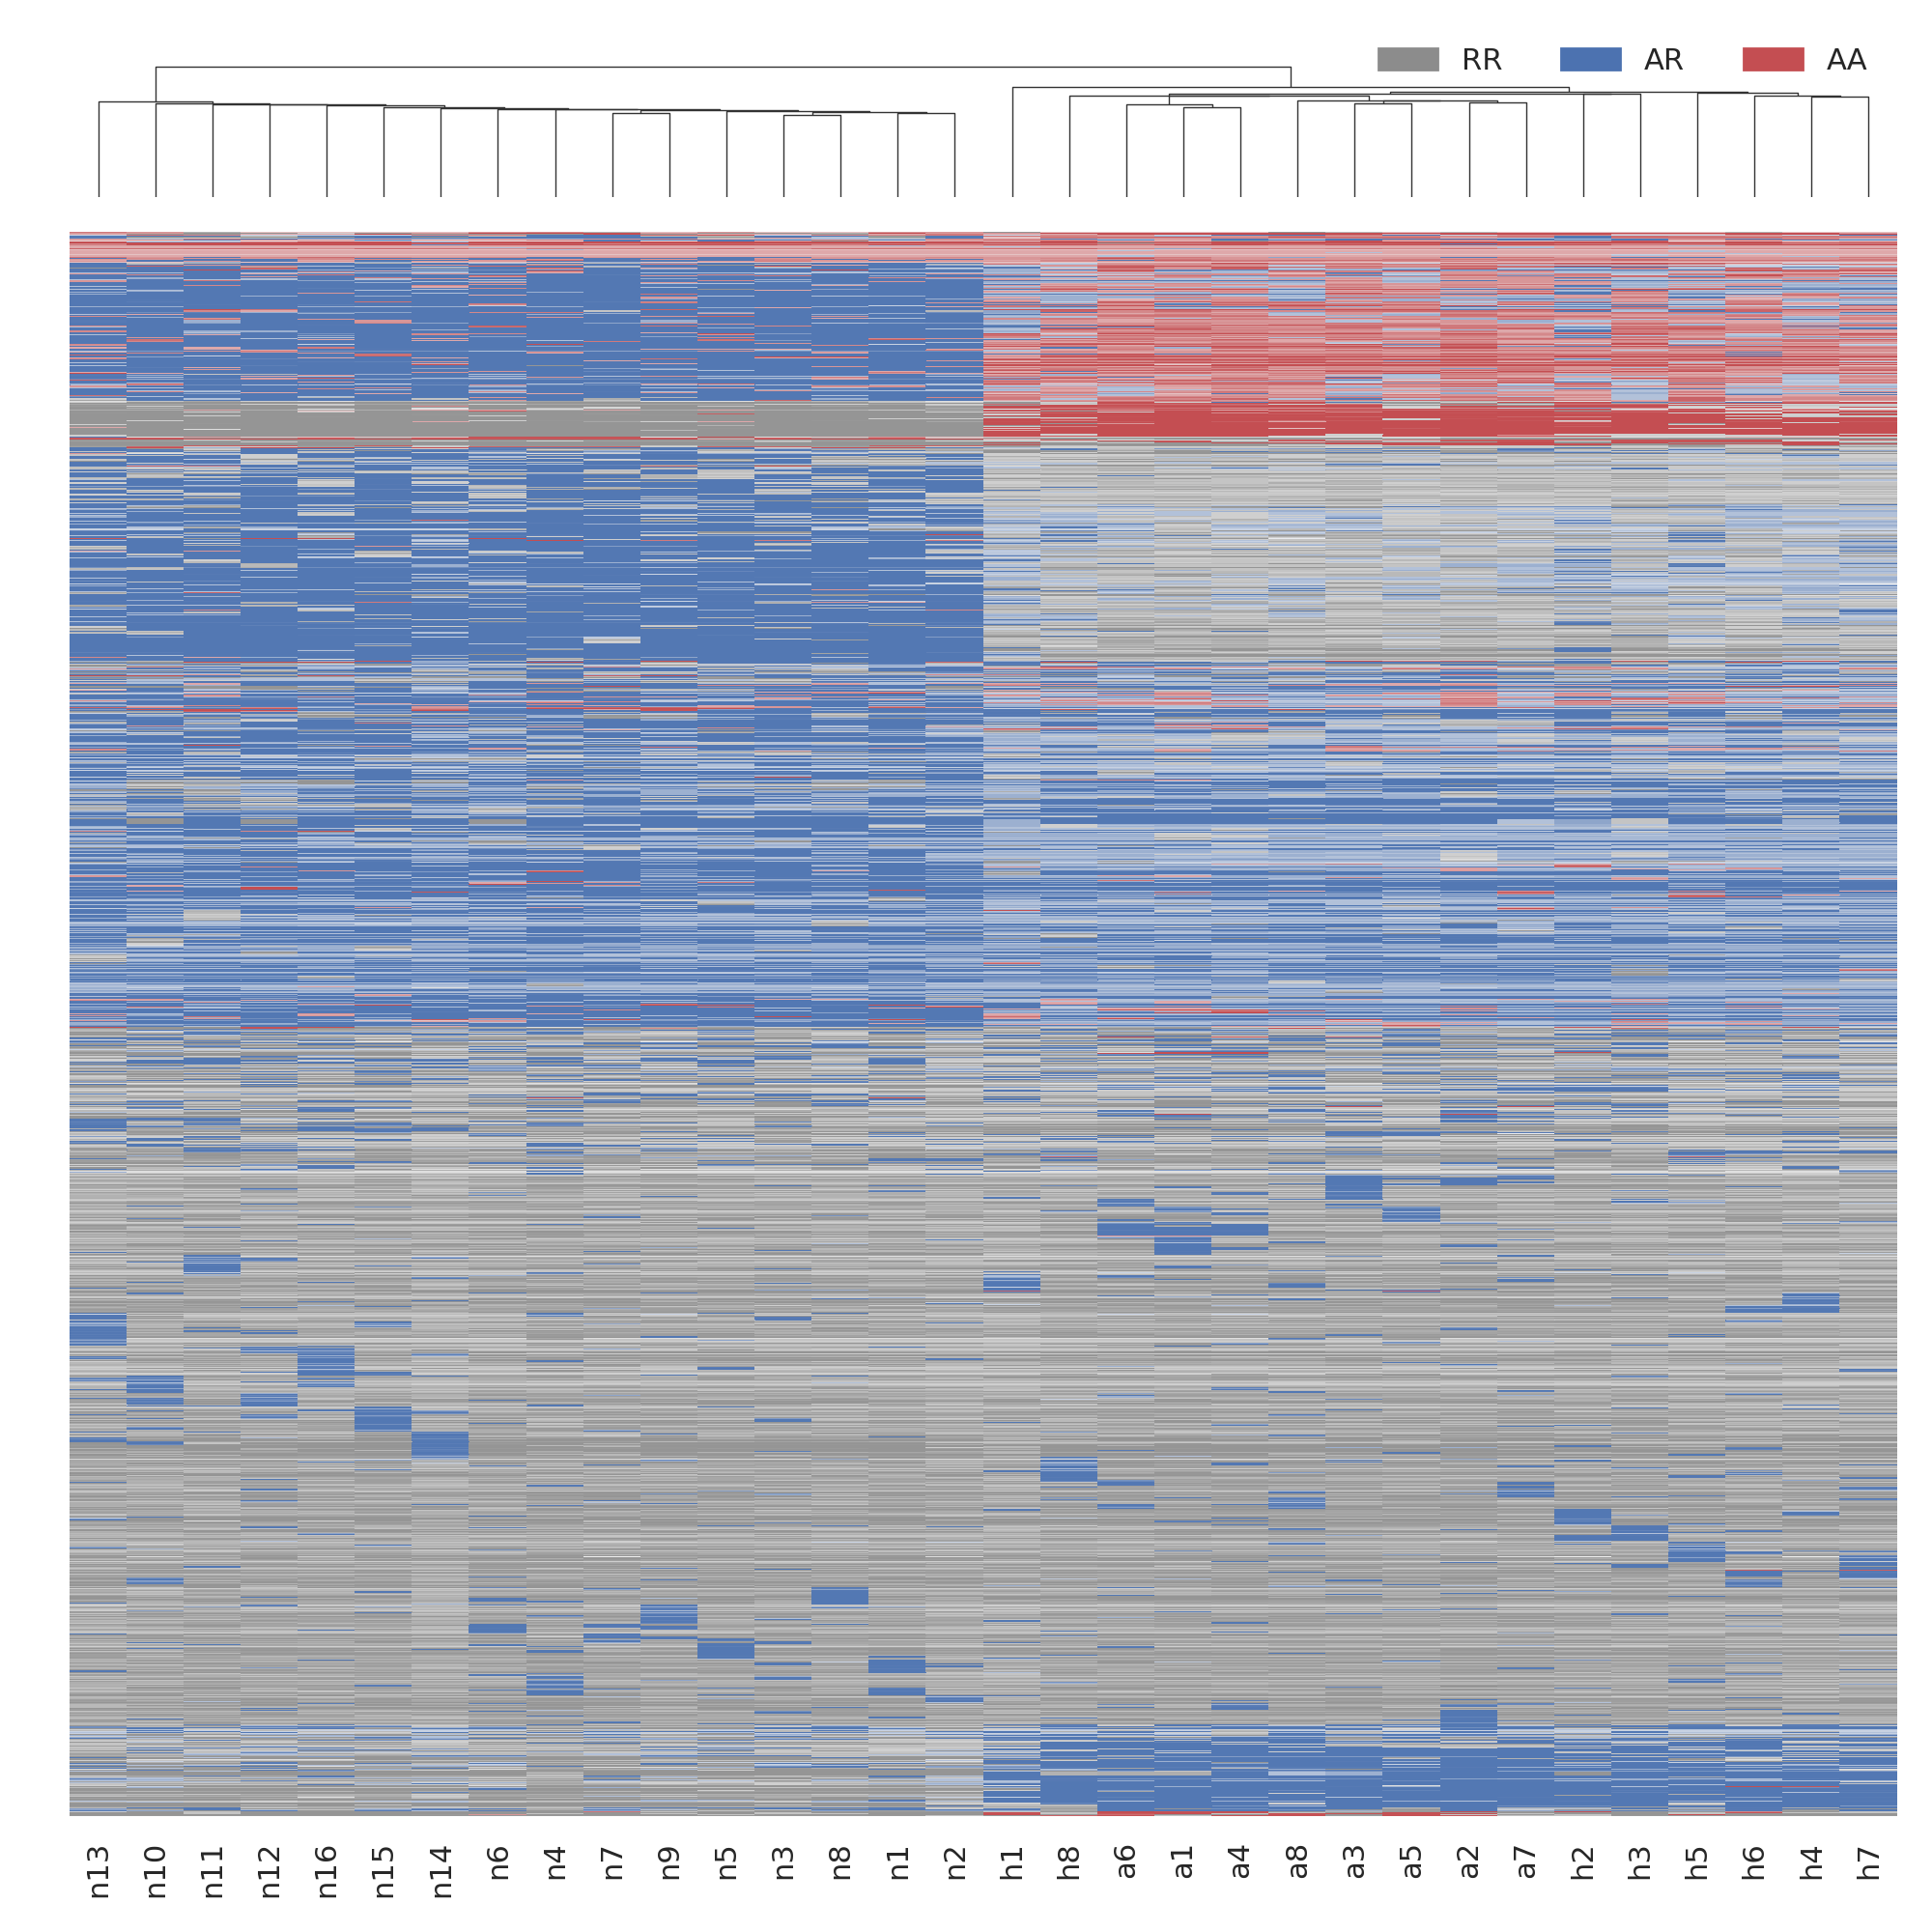

<ipython-input-931-92cba3d610d9>:27: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  g.ax_row_dendrogram.set_xlim([0,0])


In [949]:
draw_clustermap(extract_genotypes(pass_octopus_cosmic_genotypes, 2),
                method="average",
#                 linewidths=0.05,
                save = figure_dir / "wang_cosmic_pass_clustermap.pdf")

In [817]:
raw_octopus_genotypes

n1       n10       n11           n12       n13           n14  \
0       1.990000  1.997488  1.999960  1.999998e+00  3.683772  3.748811e+00   
1      -0.398107 -0.398107 -0.398107 -3.981072e-01 -0.398107 -3.981072e-01   
2      -0.006310  3.874107 -0.125893 -1.995262e-02  3.874107 -3.162278e-01   
3      -0.006310  3.874107 -0.125893 -1.995262e-02  3.874107 -3.162278e-01   
4      -0.398107  0.000000  2.000000 -3.981072e-08  0.000000 -1.995262e-09   
...          ...       ...       ...           ...       ...           ...   
163952  1.999206  1.601893  1.999206  1.990000e+00  1.748811  1.683772e+00   
163953 -0.000020 -0.398107 -0.000040 -1.000000e-02 -0.251189 -3.162278e-01   
163954 -0.005012  3.984151 -0.003162 -6.309573e-03 -0.006310  3.984151e+00   
163955  1.999684  1.683772  1.999968  1.999990e+00  1.498813 -1.584893e-01   
163956 -0.316228 -0.316228 -0.316228 -2.511886e-01 -0.398107 -3.981072e-01   

             n15           n16        n2        n3  ...            a7  \
0       3.498813  1.999937e+00  3.601893  2.000000  ...  3.841511e+00   
1      -0.398107 -3.981072e-01 -0.398107 -0.398107  ... -3.981072e-01   
2      -0.005012  3.874107e+00  3.841511 -0.158489  ...  3.874107e+00   
3      -0.005012  3.874107e+00  3.841511 -0.158489  ...  3.874107e+00   
4       0.000000 -6.309573e-02  0.000000  0.000000  ...  0.000000e+00   
...          ...           ...       ...       ...  ...           ...   
163952  1.999206  1.999206e+00  1.683772  1.999000  ...  1.999206e+00   
163953 -0.000005 -1.584893e-09 -0.316228 -0.000100  ... -3.996803e-15   
163954 -0.398107 -5.011872e-03 -0.398107 -0.003981  ... -1.258925e-03   
163955  1.601893  1.601893e+00  1.498813 -0.031623  ...  1.601893e+00   
163956 -0.398107 -3.981072e-01 -0.398107 -0.316228  ...  2.000000e+00   

                  a8            h1            h2        h3        h4  \
0       3.683772e+00  3.601893e+00  3.683772e+00  3.974881  3.960189   
1      -3.981072e-01 -3.981072e-01 -3.981072e-01 -0.398107 -0.398107   
2       3.800474e+00  3.498813e+00  3.683772e+00  3.874107  3.683772   
3       3.800474e+00  3.498813e+00  3.683772e+00  3.874107  3.683772   
4       0.000000e+00  0.000000e+00  2.000000e+00  0.000000 -0.000794   
...              ...           ...           ...       ...       ...   
163952  1.999206e+00  1.999206e+00  1.999206e+00  1.683772  1.999206   
163953 -3.996803e-15 -3.162278e-07 -3.996803e-15 -0.316228 -0.000032   
163954 -2.511886e-03 -1.995262e-04 -1.000000e-01 -0.003981 -0.006310   
163955 -7.943282e-02  1.999998e+00  1.601893e+00 -0.001995 -0.501187   
163956  2.000000e+00 -1.995262e-01  2.000000e+00  2.000000  1.999499   

                  h5        h6        h7            h8  
0       3.900000e+00  3.874107  3.601893  3.800474e+00  
1      -3.981072e-01 -0.398107 -0.398107 -3.981072e-01  
2       3.800474e+00  3.800474  3.800474  3.800474e+00  
3       3.800474e+00  3.800474  3.800474  3.800474e+00  
4      -1.000000e-03  2.000000  0.000000 -1.221245e-15  
...              ...       ...       ...           ...  
163952  1.999206e+00  1.601893  1.999000  1.683772e+00  
163953 -5.011547e-13 -0.398107 -0.000079 -3.162278e-01  
163954 -3.981072e-01 -0.398107 -0.012589 -3.162278e-03  
163955  1.601893e+00  1.498813  1.748811  1.974881e+00  
163956 -3.981072e-01  1.984151 -0.398107  2.000000e+00  

[163957 rows x 32 columns]

<IPython.core.display.Javascript object>


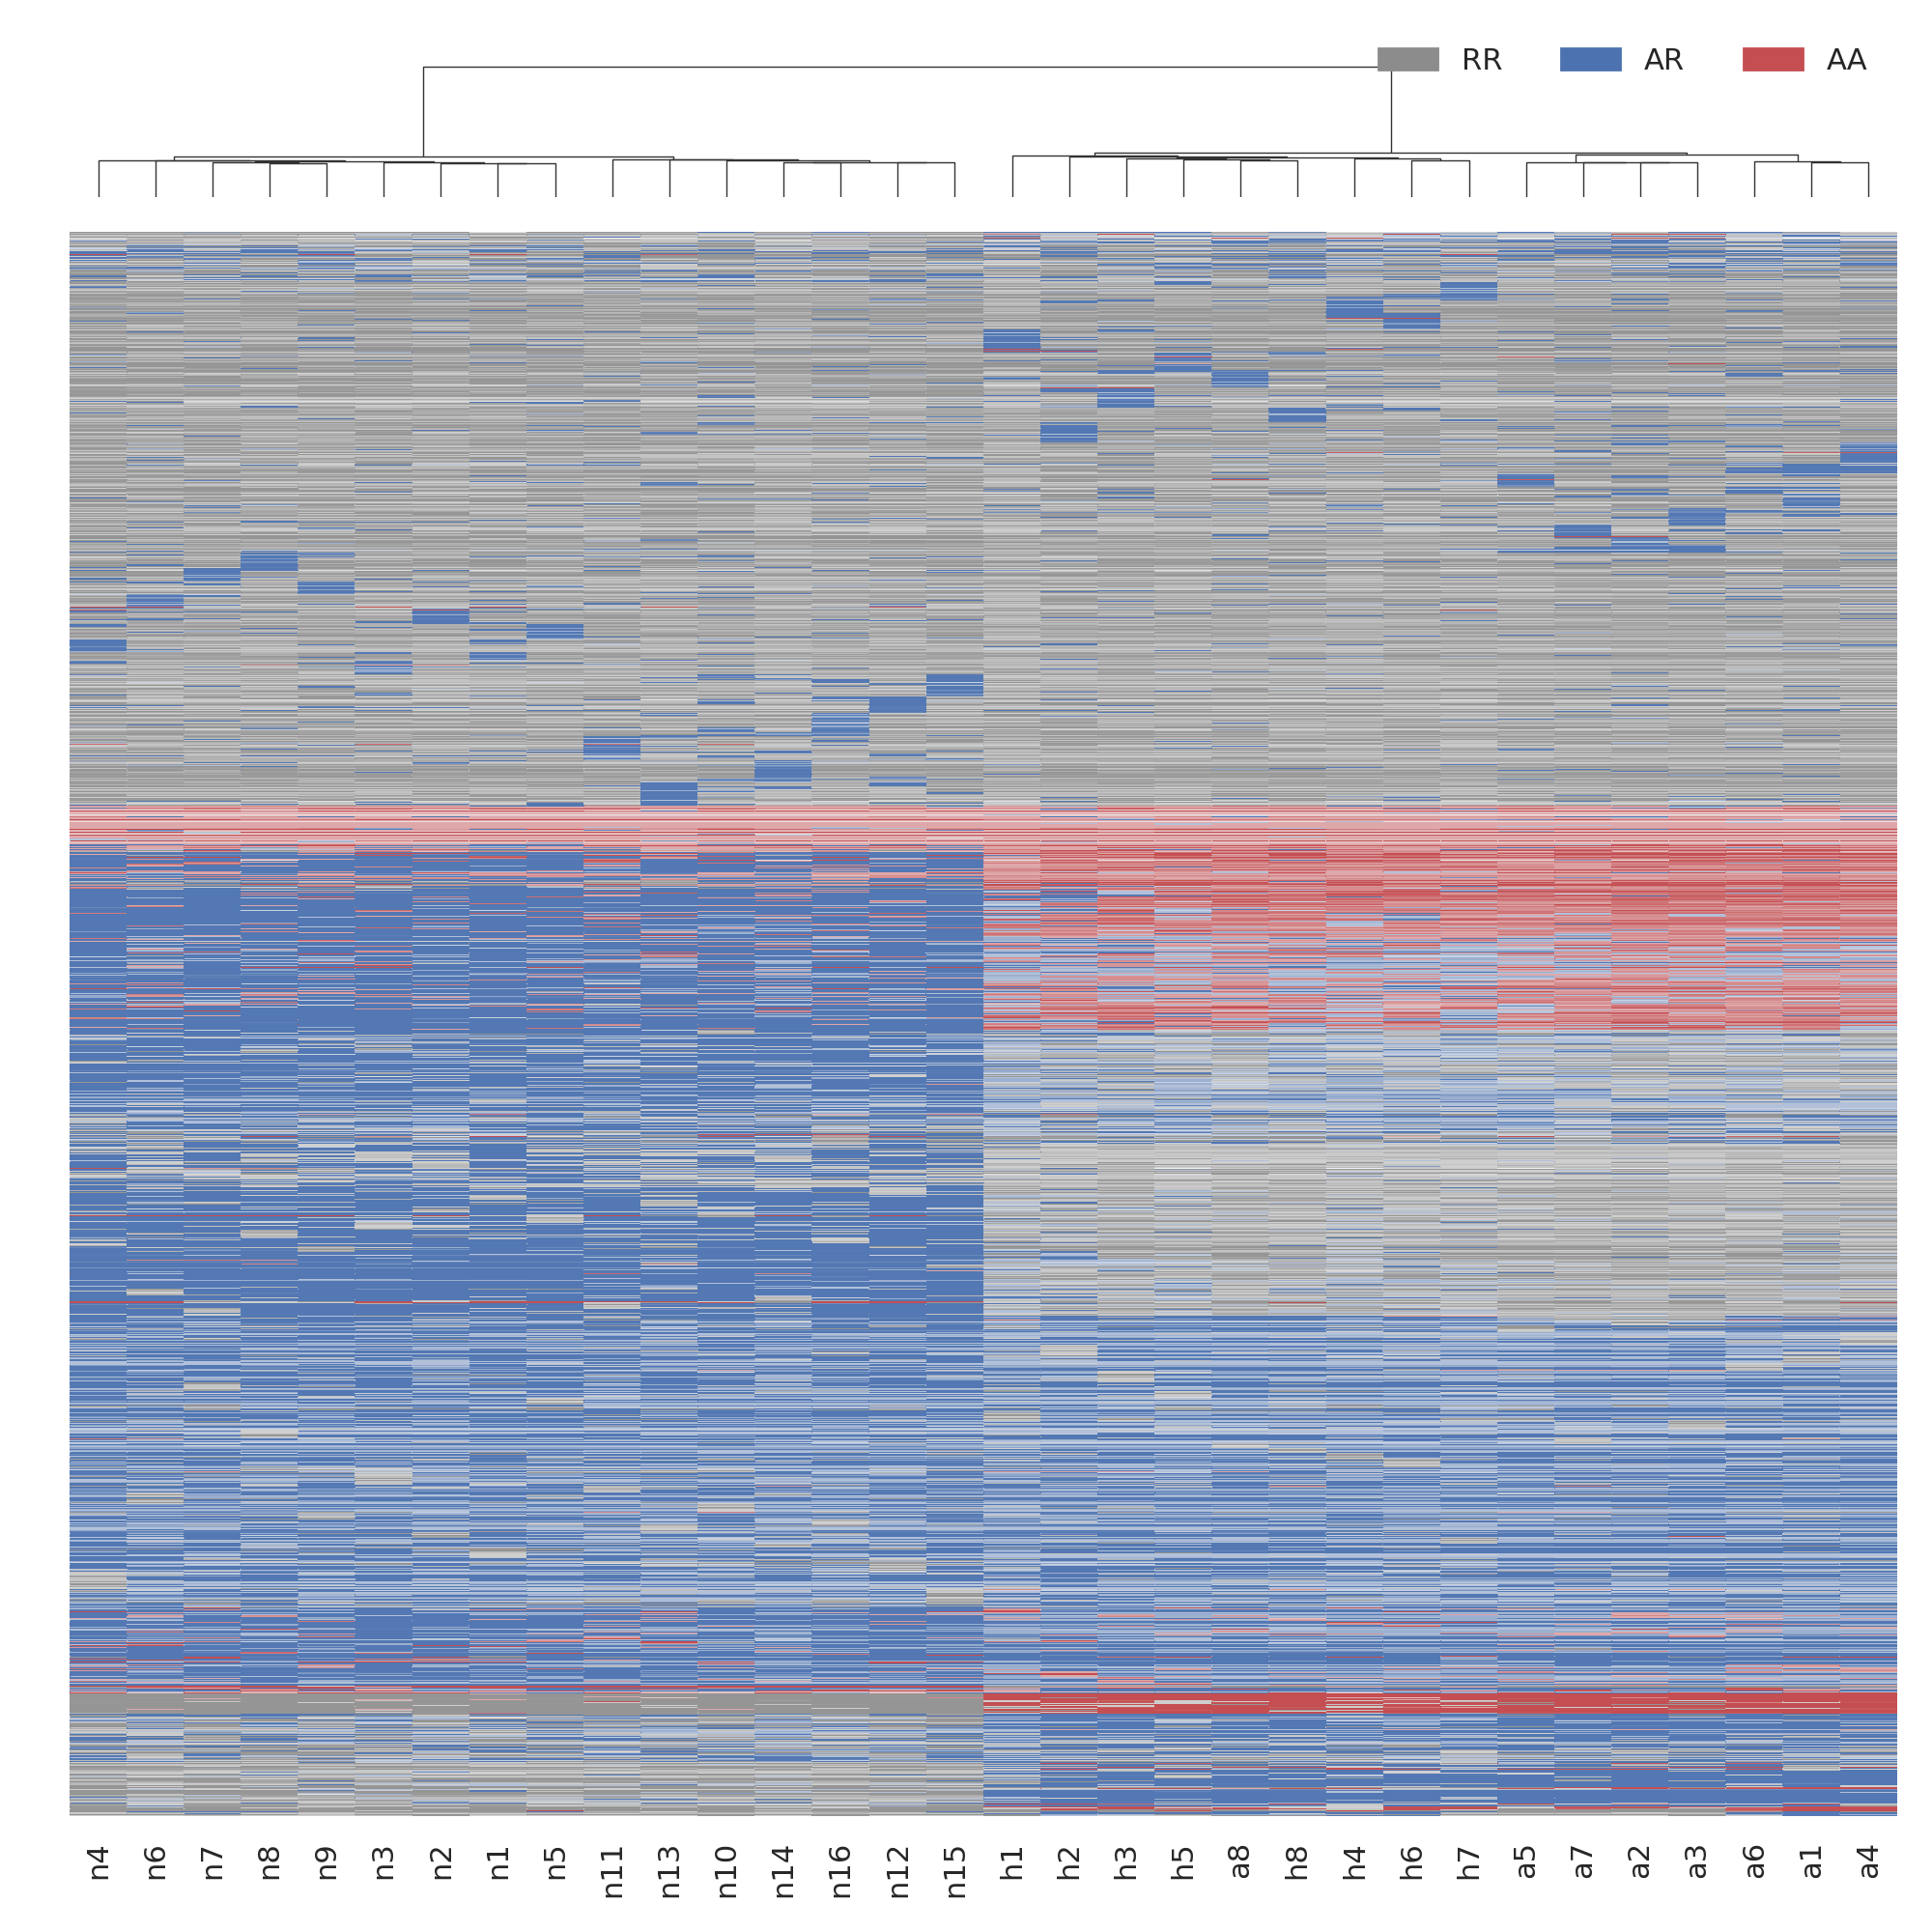

<ipython-input-931-92cba3d610d9>:27: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  g.ax_row_dendrogram.set_xlim([0,0])


In [942]:
draw_clustermap(extract_genotypes(raw_octopus_genotypes, 2),
                method="ward",
                save = figure_dir / "wang_full_clustermap.pdf")

In [903]:
raw_octopus_genotypes_discrete = rename_wang_samples(extract_genotype_matrix(octopus_vcf, confidence=False))

<IPython.core.display.Javascript object>


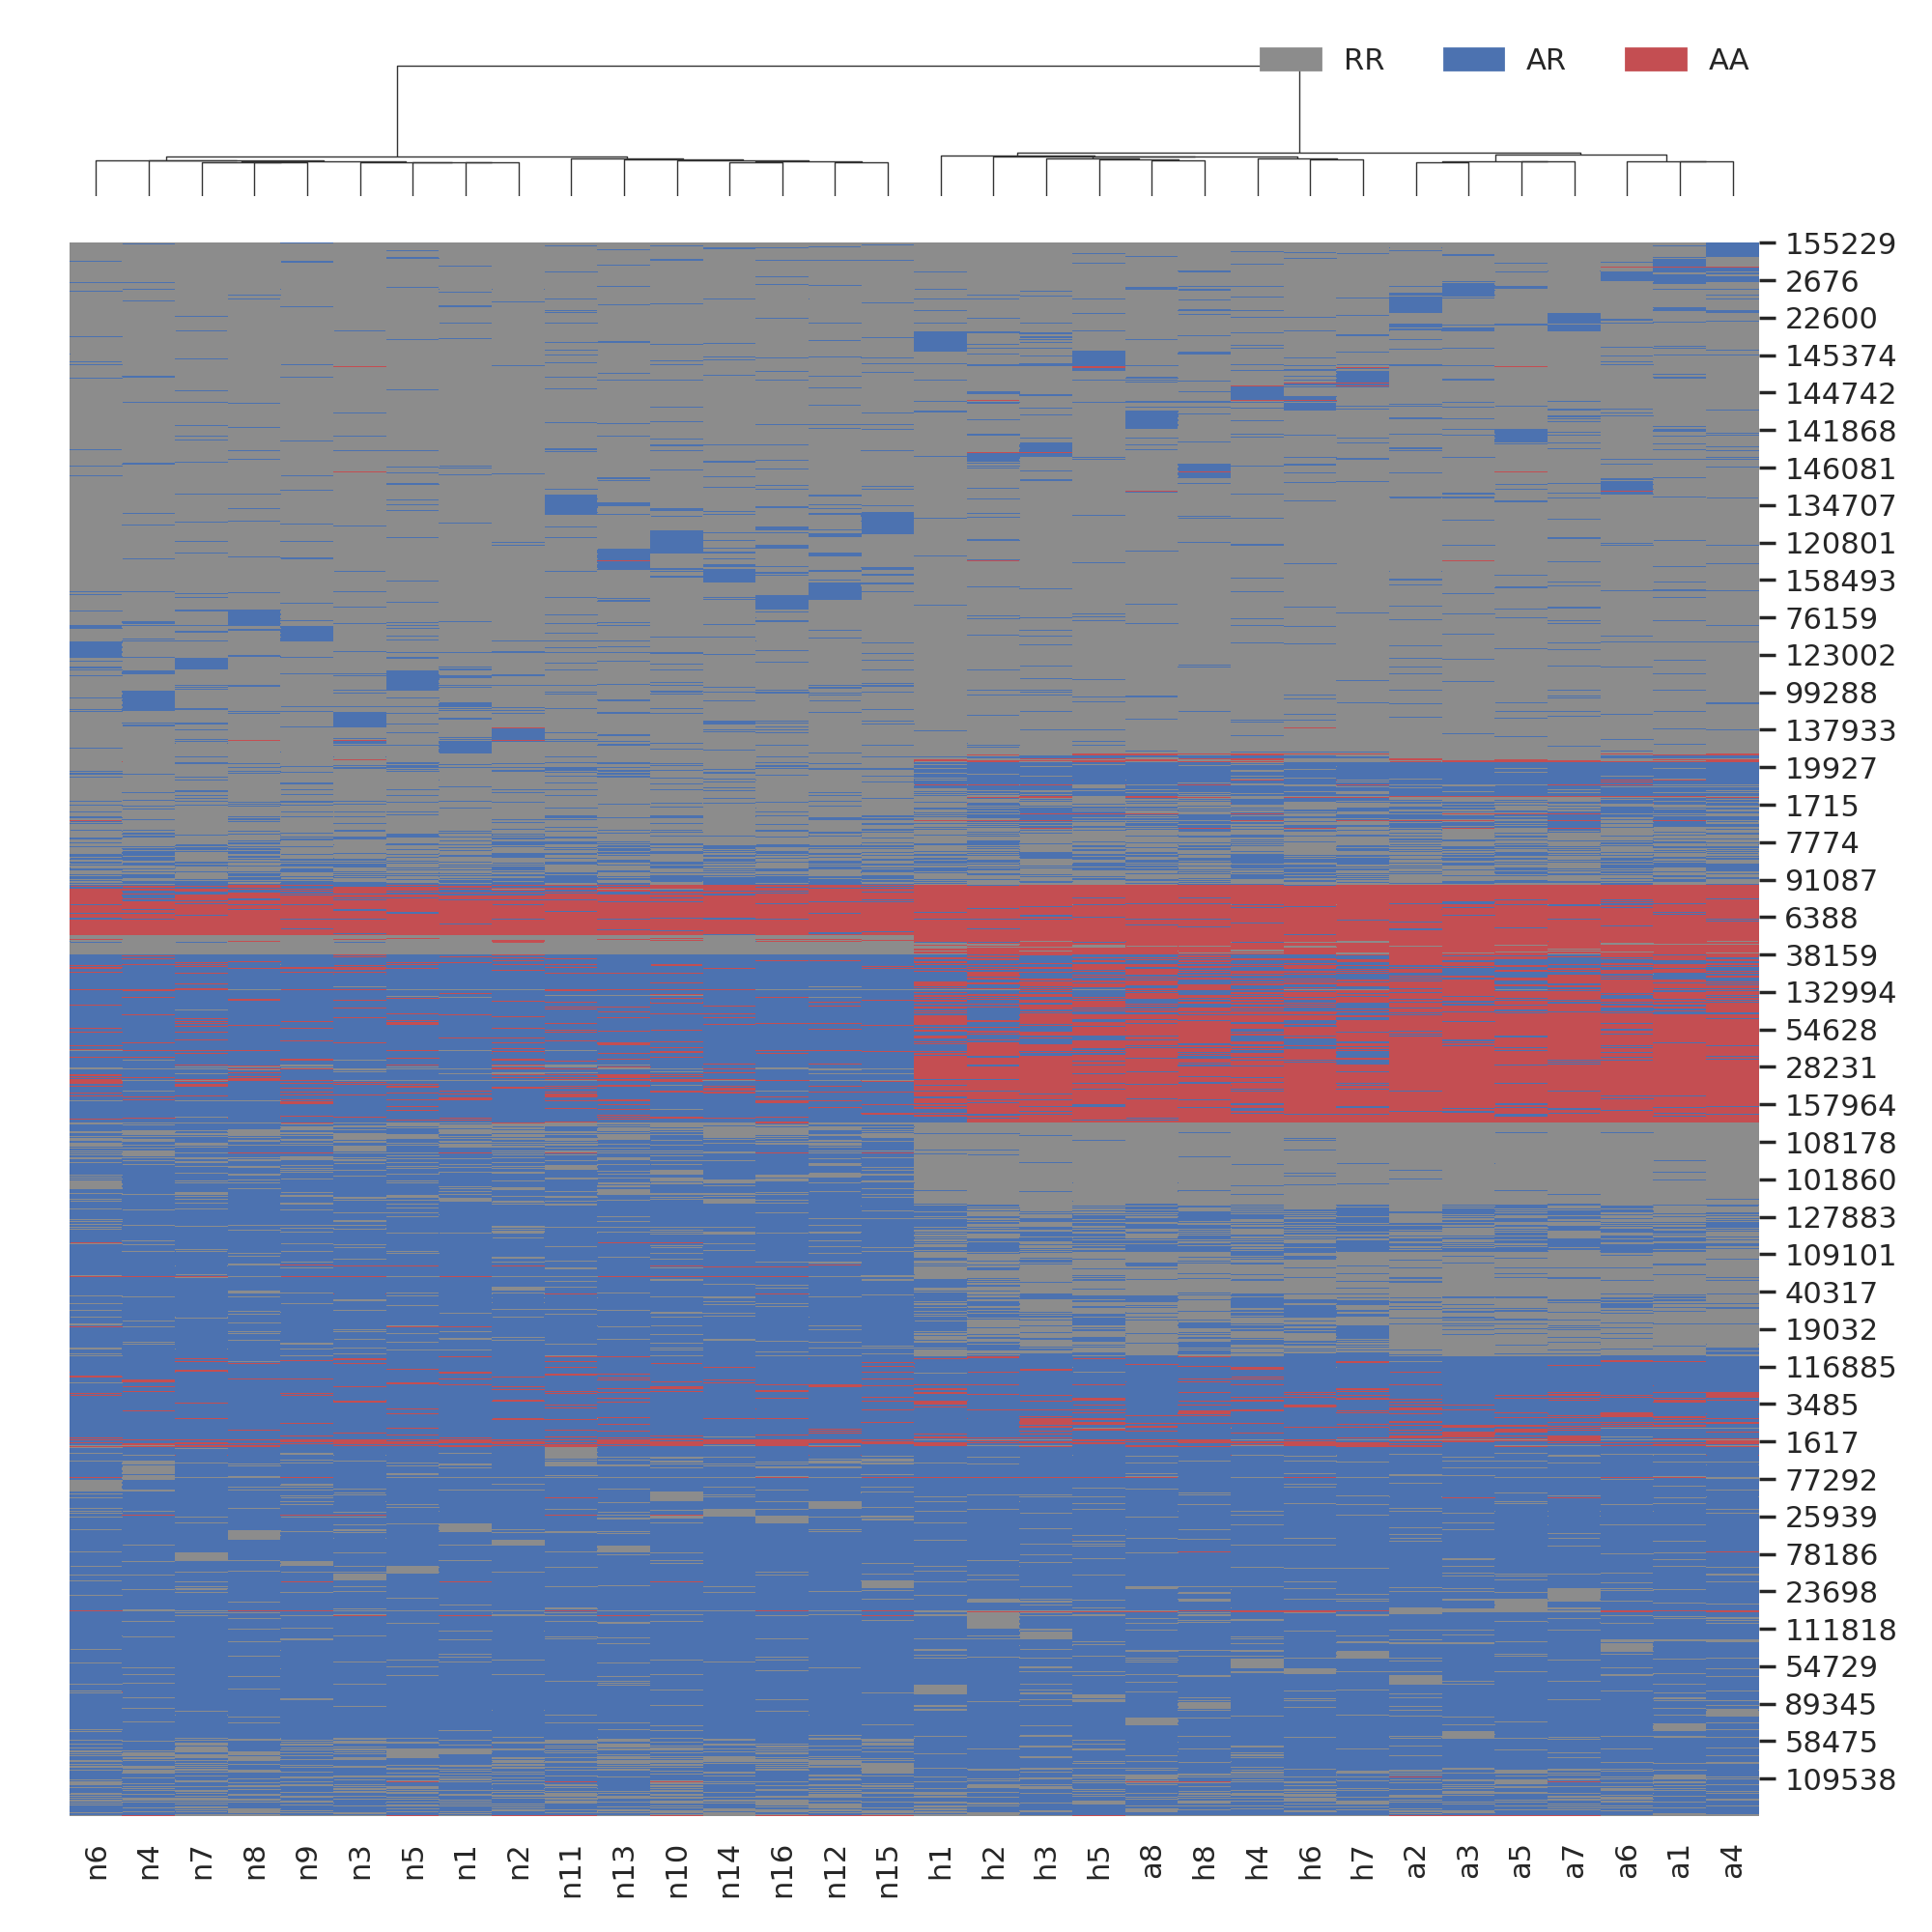

<ipython-input-892-4da6cc1659fb>:27: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  g.ax_row_dendrogram.set_xlim([0,0])


In [930]:
draw_clustermap(extract_genotypes(raw_octopus_genotypes_discrete, 1),
                method="ward", discrete=True)

In [952]:
def is_good_monovar_site(rec):
    return rec.qual > 100 \
        and all(fields["GQ"] is None or fields["GQ"] >= 3 for _, fields in rec.samples.items())

monovar_vcf = calls_dir["Wang"] / "cells.hs38DH.bwa.MonoVar.somatics.vcf.gz"
monovar_cosmic_vcf = calls_dir["Wang"] / "cells.hs38DH.bwa.MonoVar.somatics.cosmic.vcf.gz"

raw_monovar_genotypes = rename_wang_samples(extract_genotype_matrix(monovar_vcf, confidence=True))
monovar_cosmic_genotypes = rename_wang_samples(extract_genotype_matrix(monovar_cosmic_vcf, is_good_site=is_good_monovar_site, confidence=True))

In [953]:
len(monovar_cosmic_genotypes), len(raw_monovar_genotypes)

(1792, 1117566)

<IPython.core.display.Javascript object>


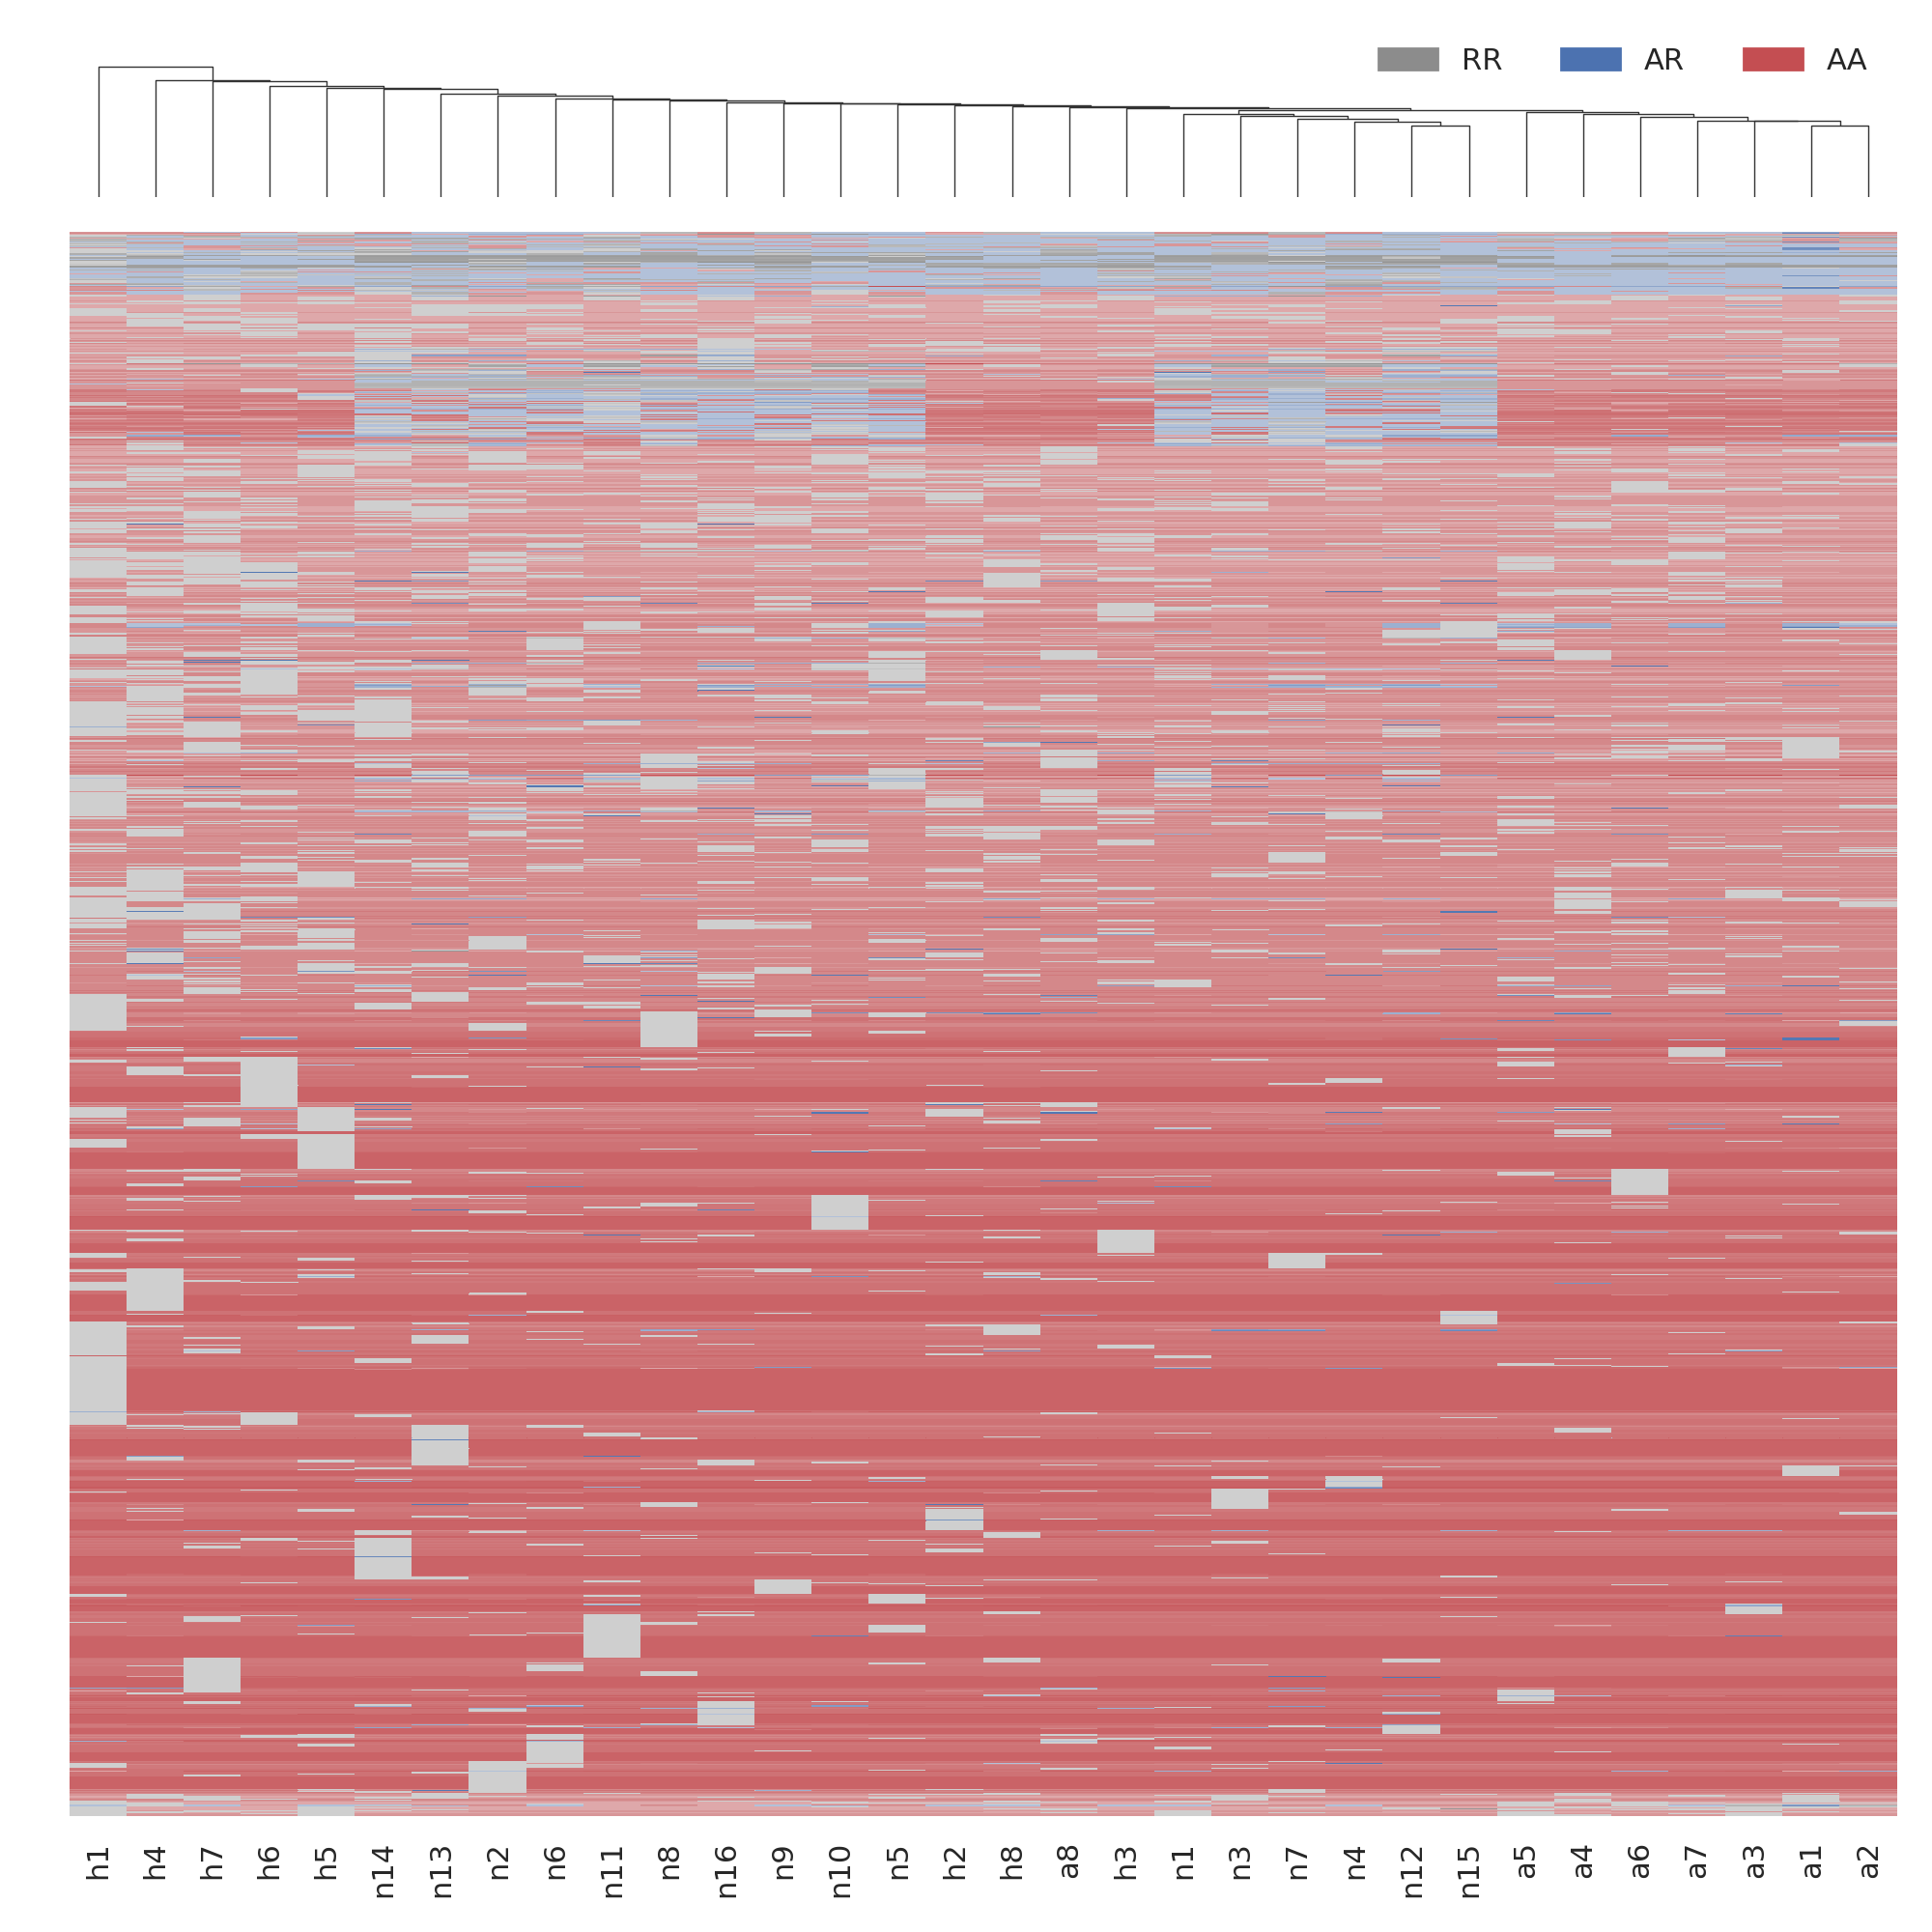

<ipython-input-931-92cba3d610d9>:27: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  g.ax_row_dendrogram.set_xlim([0,0])


In [954]:
draw_clustermap(extract_genotypes(monovar_cosmic_genotypes, 2), 
                method="average",
                save = figure_dir / "wang_cosmic_clustermap_monovar.pdf"
               )

In [408]:
def is_good_sccaller_site(rec):
    return True

sccaller_vcf = calls_dir["Wang"] / "cells.hs38DH.bwa.SCcaller.somatics.vcf.gz"
sccaller_genotypes = extract_genotype_matrix(sccaller_vcf, is_good_site=is_good_sccaller_site, confidence=True)

sccaller_genotypes = rename_wang_samples(sccaller_genotypes)

In [492]:
extract_genotypes(sccaller_genotypes, 2, 31)

a1        a2   a3        a4        a5        a6        a7  \
48   0.498813  0.498813  0.0  0.000000  0.000000  0.000000  0.498813   
88   0.000000  0.000000  0.0  0.498813  0.498813  0.000000  0.000000   
101  0.000000  0.000000  0.0  1.000000  0.000000  1.000000  0.000000   
107  0.000000  0.000000  0.0  0.000000  0.498813  0.874107  0.498813   

           a8   h1      h2  ...  n7  n8  n9  n10  n11  n12  n13  n14  n15  n16  
48   0.498813  0.0  0.0000  ...   0   0   0    0    0    0    0    0    0  0.0  
88   0.000000  0.0  0.9998  ...   0   0   0    0    0    0    0    0    0  0.0  
101  1.000000  0.0  0.0000  ...   0   0   0    0    0    0    0    0    0  0.0  
107  0.000000  0.0  0.0000  ...   0   0   0    0    0    0    0    0    0  0.0  

[4 rows x 32 columns]

<IPython.core.display.Javascript object>


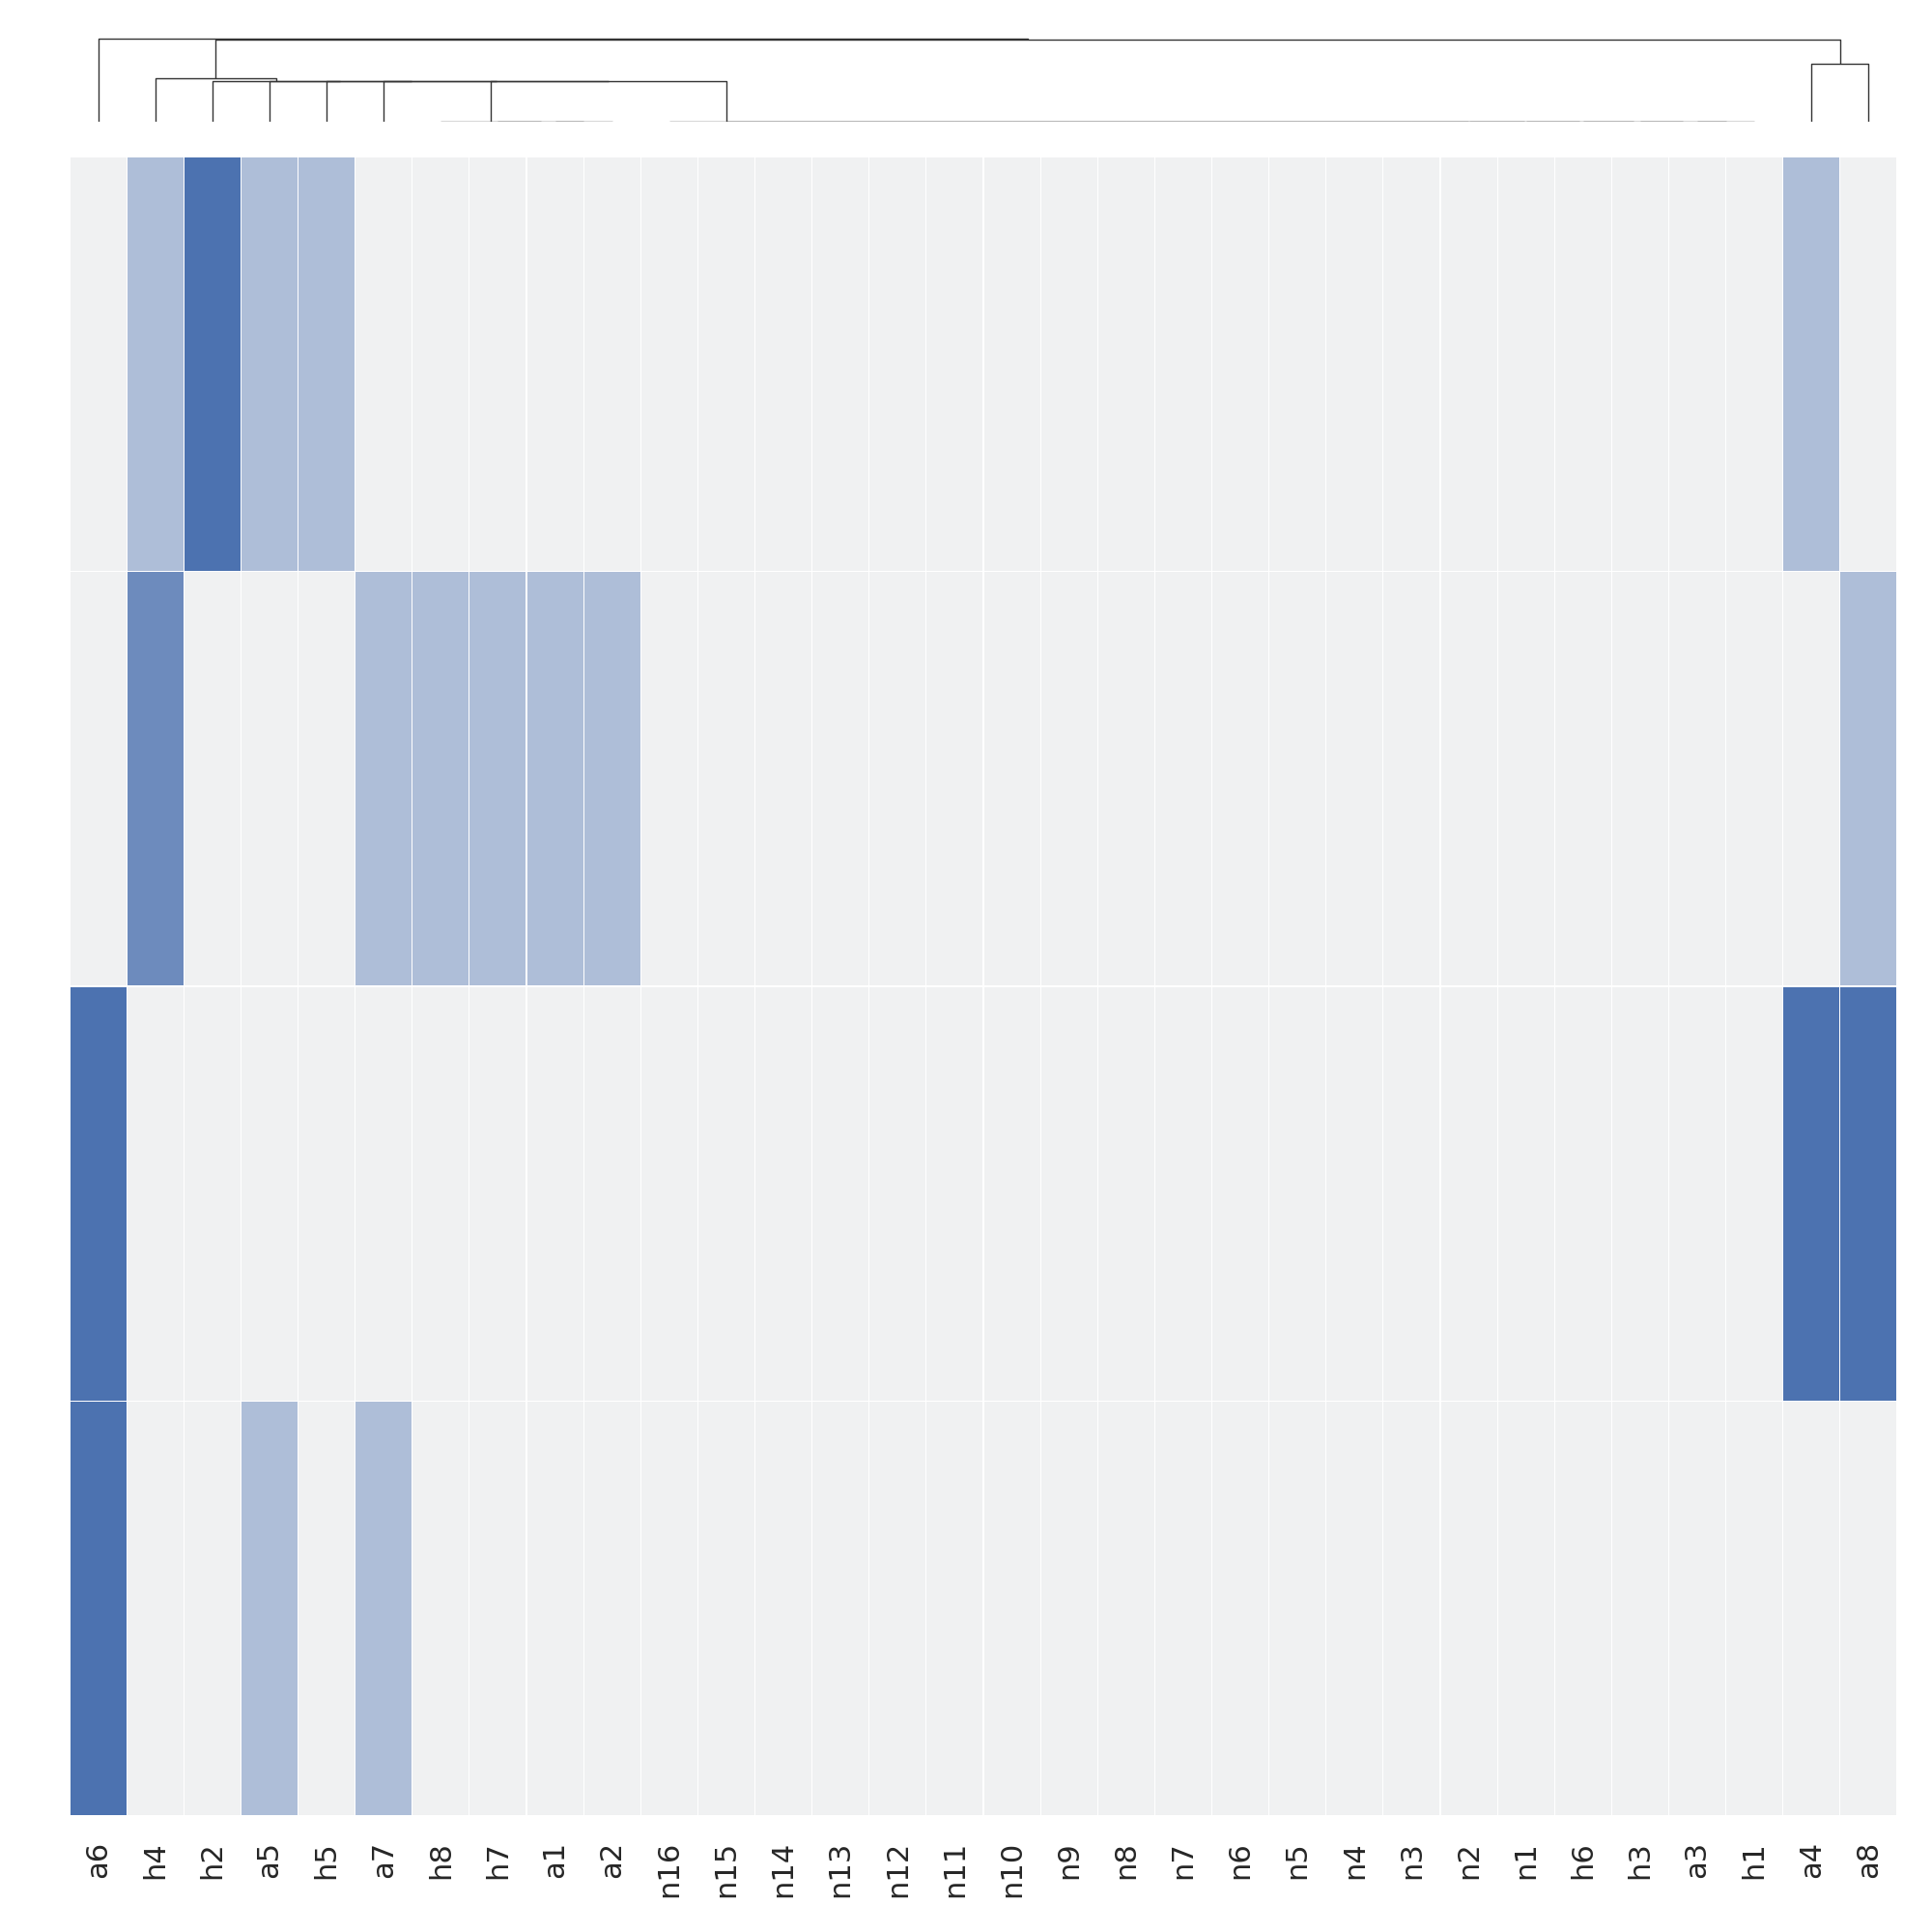

<ipython-input-400-5f511fceb860>:22: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  g.ax_row_dendrogram.set_xlim([0,0])


In [410]:
draw_clustermap(extract_genotypes(sccaller_genotypes, 2))

In [1000]:
def is_good_prosolo_site(rec):
    return rec.qual > 50

prosolo_cosmic_vcf = calls_dir["Wang"] / "cells.hs38DH.bwa.Prosolo.somatics.cosmic.vcf.gz"
prosolo_cosmic_genotypes = rename_wang_samples(extract_genotype_matrix(prosolo_cosmic_vcf, is_good_site=is_good_prosolo_site, confidence=True))

In [1003]:
extract_genotypes(prosolo_cosmic_genotypes, 2)

a1  normal_cells        a2  2:normal_cells        a3  \
0     3.888234      3.888234  1.533333        1.533333  3.911213   
1     3.518180      3.518180  1.646258        1.646258 -0.501187   
2     3.568744      3.568744  3.592053        3.592053  3.568744   
3     1.985207      1.985207  1.989060        1.989060  3.879199   
4     1.654006      1.654006  1.654006        1.654006  3.624675   
...        ...           ...       ...             ...       ...   
6600  1.687992      1.687992  1.870075        1.870075  3.647100   
6601  1.986846      1.986846  3.680548        3.680548  1.622223   
6602  1.988303      1.988303 -0.501187       -0.501187 -0.501187   
6603 -0.501187     -0.501187 -0.501187       -0.501187  1.998091   
6604 -0.501187     -0.501187 -0.501187       -0.501187  3.586455   

      3:normal_cells        a4  4:normal_cells        a5  5:normal_cells  ...  \
0           3.911213  1.533333        1.533333  1.533333        1.533333  ...   
1          -0.501187  1.571442        1.571442  1.571442        1.571442  ...   
2           3.568744  3.568744        3.568744  3.568744        3.568744  ...   
3           3.879199  1.828846        1.828846  1.830522        1.830522  ...   
4           3.624675  1.889173        1.889173  1.969849        1.969849  ...   
...              ...       ...             ...       ...             ...  ...   
6600        3.647100  1.994696        1.994696  1.986313        1.986313  ...   
6601        1.622223  1.986840        1.986840  1.980896        1.980896  ...   
6602       -0.501187 -0.501187       -0.501187 -0.501187       -0.501187  ...   
6603        1.998091 -0.501187       -0.501187  3.900620        3.900620  ...   
6604        3.586455 -0.501187       -0.501187  3.598106        3.598106  ...   

           n12  28:normal_cells       n13  29:normal_cells       n14  \
0     1.533333         1.533333  1.533333         1.533333  1.533333   
1     3.758492         3.758492 -0.501187        -0.501187  1.768326   
2     3.813838         3.813838  3.903644         3.903644  3.748604   
3     1.656763         1.656763  1.909583         1.909583  1.670826   
4     3.696107         3.696107  3.846980         3.846980  1.783473   
...        ...              ...       ...              ...       ...   
6600  1.636364         1.636364  3.829434         3.829434  1.991895   
6601  3.769328         3.769328  3.804087         3.804087  3.647734   
6602  3.944046         3.944046  1.798076         1.798076 -0.501187   
6603 -0.501187        -0.501187  1.859498         1.859498 -0.501187   
6604  1.950662         1.950662 -0.501187        -0.501187 -0.501187   

      30:normal_cells       n15  31:normal_cells       n16  32:normal_cells  
0            1.533333  1.533333         1.533333  1.533333         1.533333  
1            1.768326  3.747611         3.747611 -0.501187        -0.501187  
2            3.748604  1.634409         1.634409  1.634409         1.634409  
3            1.670826  1.819090         1.819090  3.748611         3.748611  
4            1.783473  1.971720         1.971720  3.841876         3.841876  
...               ...       ...              ...       ...              ...  
6600         1.991895  1.636364         1.636364  3.746082         3.746082  
6601         3.647734  1.622223         1.622223  1.622223         1.622223  
6602        -0.501187  1.962928         1.962928  1.983333         1.983333  
6603        -0.501187  1.991763         1.991763 -0.501187        -0.501187  
6604        -0.501187  1.989405         1.989405 -0.501187        -0.501187  

[6605 rows x 64 columns]

<IPython.core.display.Javascript object>


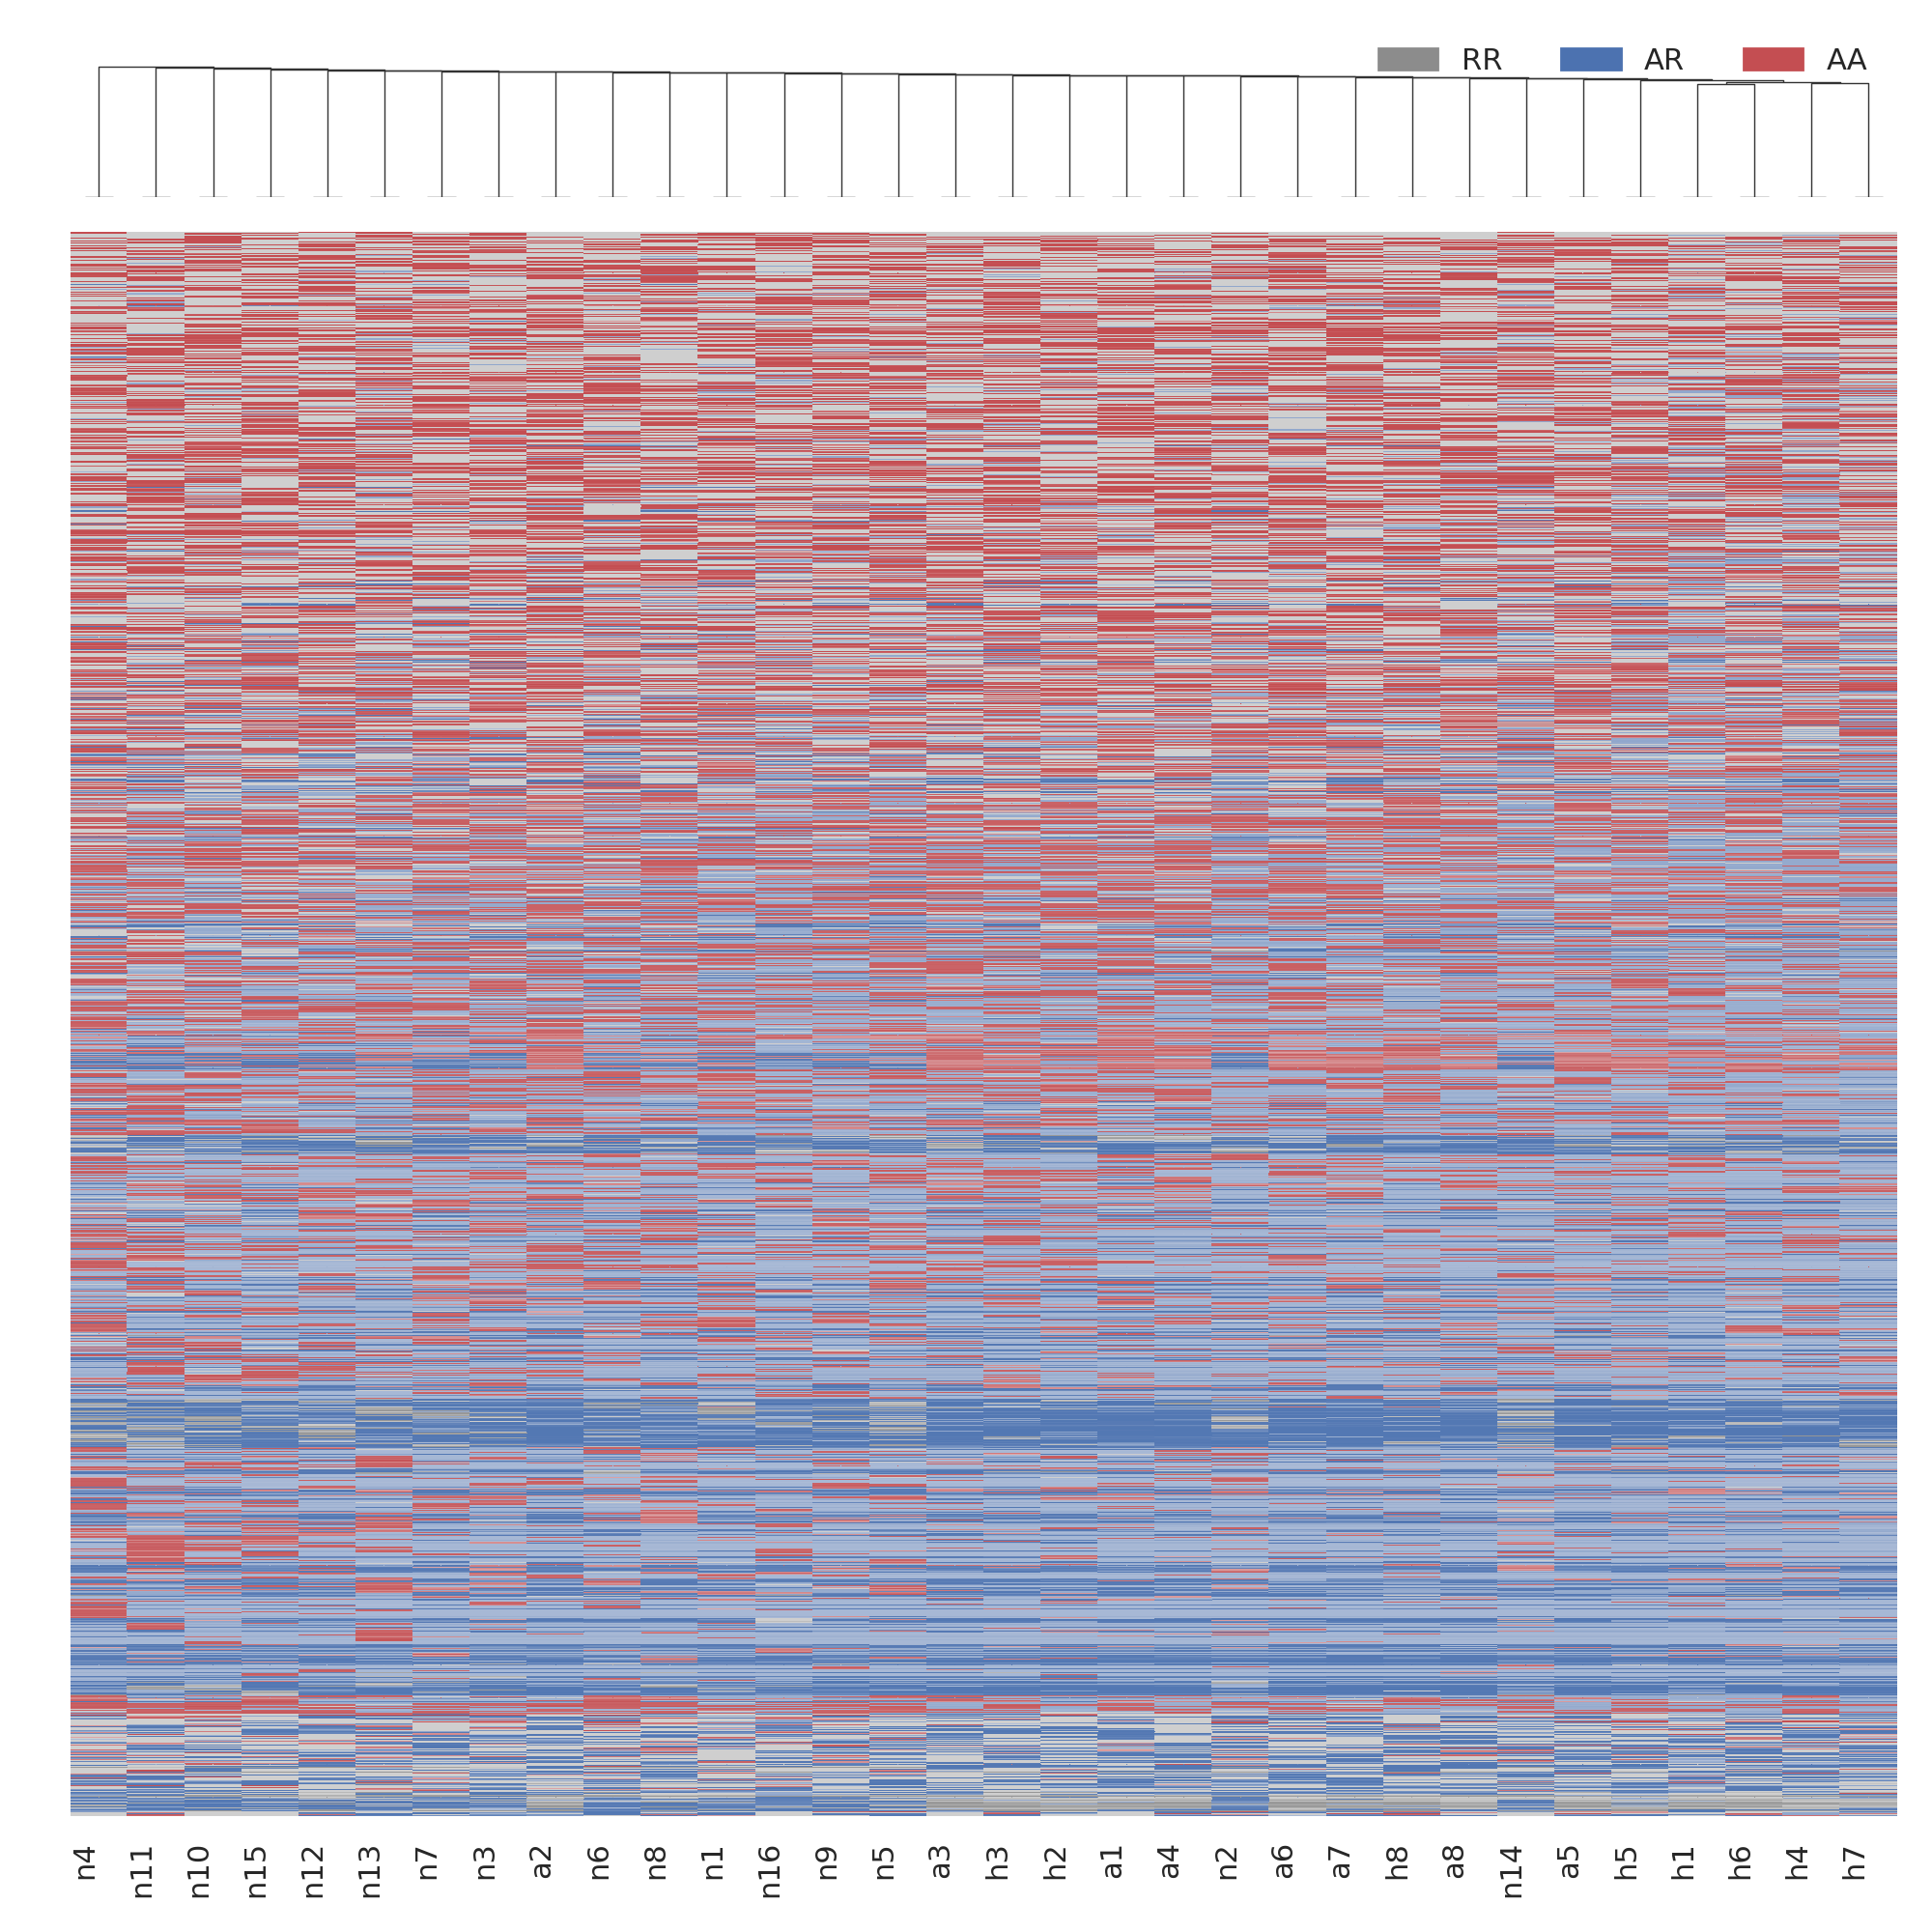

<ipython-input-931-92cba3d610d9>:27: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  g.ax_row_dendrogram.set_xlim([0,0])


In [1002]:
draw_clustermap(extract_genotypes(prosolo_cosmic_genotypes, 2),
                method="average",
                save = figure_dir / "wang_cosmic_clustermap_prosolo.pdf")

In [807]:
caller_pass_conditions = {
    "Octopus": is_good_octopus_site,
    "MonoVar": is_good_monovar_site,
    "Prosolo": is_good_prosolo_site,
}

dfs = []
for caller in ["Octopus", "SCcaller", "MonoVar"]:
    caller_vcf = calls_dir["Wang"] / ("cells.hs38DH.bwa." + caller + ".somatics.vcf.gz")
    if caller_vcf.exists():
        pass_condition = caller_pass_conditions[caller] if caller in caller_pass_conditions else default_pass_condition
        isecs = intersect_samples(caller_vcf, is_pass=pass_condition)
        isecs["Caller"] = caller
        isecs["Match"] = "GT"
        allele_isecs = intersect_samples(caller_vcf, genotypes=False, is_pass=pass_condition)
        allele_isecs["Caller"] = caller
        allele_isecs["Match"] = "AL"
        dfs += [isecs, allele_isecs]
wang_isecs_df = pd.concat(dfs)

In [808]:
wang_agg_isecs_df = wang_isecs_df.groupby(["Caller", "Match", "Cells"]).aggregate({"Count": "sum", "Missing": "sum"}).reset_index()

In [809]:
wang_agg_isecs_df.query("Match=='GT'").groupby("Caller").agg({"Count": "sum"})

Count
Caller         
MonoVar   47205
Octopus   23198
SCcaller    128

<IPython.core.display.Javascript object>


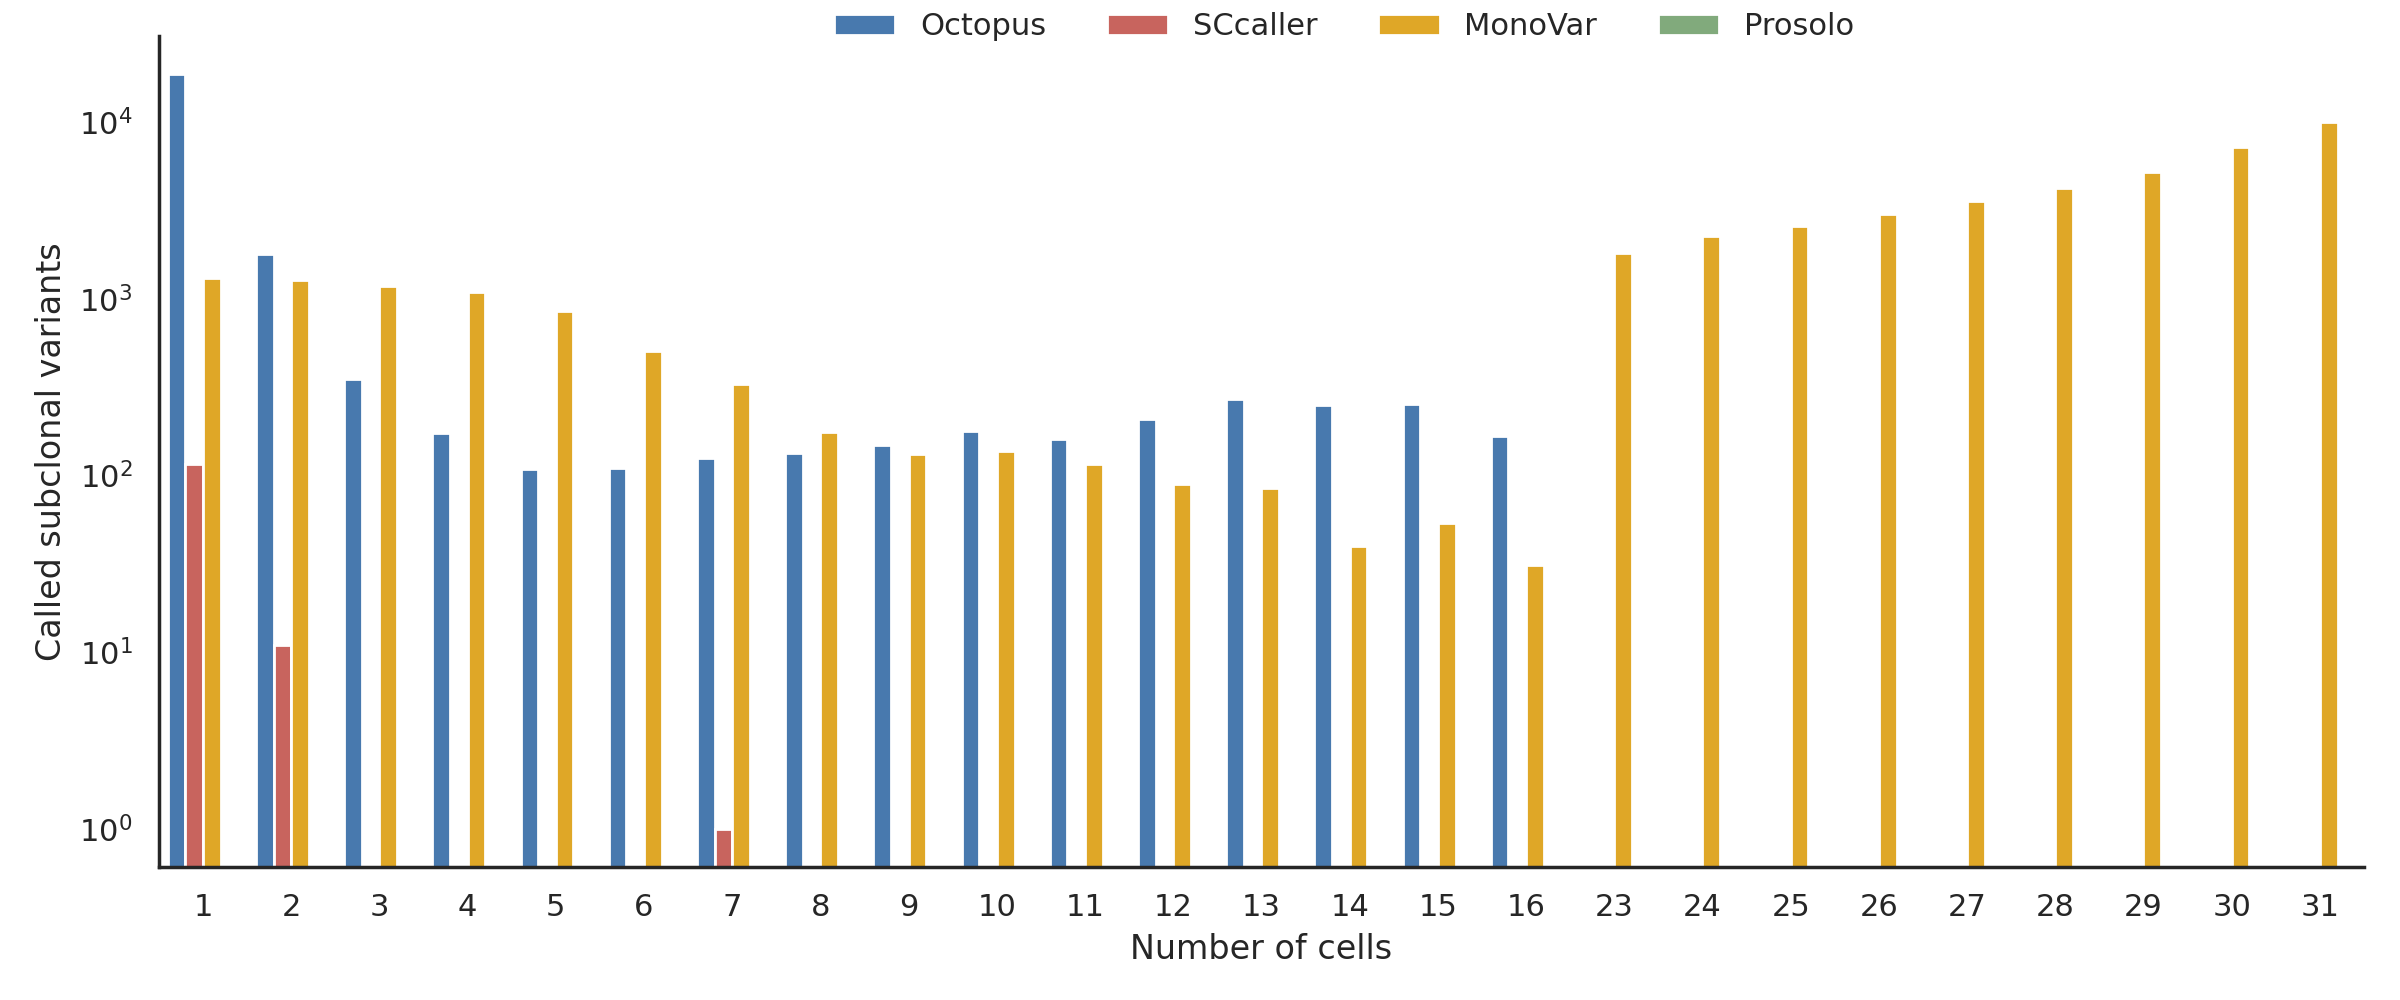

In [810]:
sns.set(style="white")
fig, ax = plt.subplots(figsize=(12, 5))
g = sns.barplot(x="Cells", y="Count", 
                hue="Caller",
                hue_order=caller_order,
                palette=caller_colours, ci=None,
                data=wang_agg_isecs_df.query("Match=='GT'"),
                ax=ax)
sns.despine(ax=ax)
ax.set_yscale('log')
ax.set(xlabel='Number of cells', ylabel='Called subclonal variants')
handles, labels = ax.get_legend_handles_labels()
lgd = fig.legend(handles=handles, labels=labels, frameon=False,
                 loc='upper center', 
                 bbox_to_anchor=(0.56, 1.),
                 borderaxespad=0, ncol=len(labels))
ax.legend_.remove()
plt.tight_layout()

In [1004]:
with open("/well/gerton/dan/rescomp/multiple_myeloma_cell.octopus.v0.7.3.376051a6.population.psrecord.log") as f:
    columns = next(f)
    data = []
    for line in f:
        fields = line.strip().split()
        data.append(fields)
    resources = pd.DataFrame(data, columns=columns)

KeyboardInterrupt: 